# **Spatial Estimation of Chronic Respiratory Disease Based on Geospatial Machine Learning Procedures - An Approach Using Earth-Engine-Based Remote Sensing Data and Air Quality Variables in the State of Pennsylvania**

**Emily Zhou, Shuai Wang**

*Department of City and Regional Planning, Weitzman School of Design, University of Pennsylvania*

Version 3.0 | First Created Apr 1, 2024 | Updated May 03, 2024

Keywords: support vector machine, random forest, multiple layer perceptron, deep learning, bayesian information criteria, google earth engine, geospatial health

Important Links: [original paper](https://doi.org/10.1016/j.apgeog.2020.102273), [project repository](https://github.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/tree/main)



## **1. Introduction**

In the past few years, remote sensing data have increasingly been used in monitoring, spatial predicting modeling, and risk assessment with respect to human health for their ability to facilitate the identification of social and environment determinants of health and to provide consistent spatial and temporal coverage of study data. In the meantime, machine learning techniques have been widely used in public health research to enhance the accuracy of disease prediction and early detection, improve the efficiency of healthcare resource allocation, and enable the development of personalized treatment plans.

As an example of applying remote sensing data and machine learning techniques in health research, Alvarez-Mendoza et al. conducted a study in 2020, in which they proposed to estimate the prevalence of Chronic Respiratory Diseases (CRDs) by examining the relationship between remote sensing data, air quality variables, and the number of hospital discharges of patients with CRDs in Quito, Ecuador. Specifically, their study estimated and compared three different complex machine learning techniques, support vector regression, random forest regression, and multiple layer perceptron, in predicting CRD rate, considering the effect of environmental variables, air pollution field measurements, and meteorological data. Their goal is to provide insights into and an understanding of the most significant spatial predictors and the spatial distribution of HCRD in the city of Quito.

For a detailed description of Alvarez-Mendoza et al's methodology and workflow, please refer to the workflow below and the presentation slides [here](https://github.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/blob/main/documents/slides.pptx).

![workflow](https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/documents/RS-research.jpeg)


In our final project, we plan to replicate and improve upon Alvarez-Mendoza et al.’s study and investigate the effectiveness of several machine learning models in predicting the number of hospital discharge patients with CRD in the state of Pennsylvania. Following their established workflow, we combined multiple data sources, including specific bands of satellite imageries, different kinds of vegetation indices, monthly air pollutant measures, and meterological indicators, as proxies for local environment to analyze the distribution of CRD hospitalizations across the Pennsylvania. **Our goal is to understand the most significant environmental and atmospheric factors leading to higher CRD risk in Pennsylvania as well as to compare the performance of different machine learning models.**

Our biggest deviation from Alvarez-Mendoza et al.’s study is to conduct the analysis at a much larger geographic extent. Since our raw data all comes from different sources and with different geographic unit (eg. hospital discharge data are collected a county level while remote sensing data are at 30\*30m spatial resolution), we divide Pennsylvania into 8397 5000\*5000m contiguous fishnet grids. Doing so provide a regular and systematic way to divide geographic areas into smaller units. It simplifies our analysis by providing a structured framework for organizing and processing spatial data. Another major deviation from the original study is the availability of air quality data in Pennsylvania. Because the influence of air quality monitoring stations is not limited by administrative boudaries, making spatial interpolation of their influence zone becomes an important step before analysis. We computed several voronoi polygons based on station locations that collect different kinds of air quality data. Each station is associated with a polygon representing the area where it has the closet proximity, from which we could then aggregate to the fishnet. The third deviation is that we took seasonality into account while running the machine learning model. Specifically, models were ran on data from different seasons separately for cross-comparison. For reference, here is our modified workflow, with the modified part highlited in green.

![workflow2](https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/documents/RPI-workflow.jpeg)

This notebook documents our entire replication study and is organized into the following sections following the workflow of Alvarez-Mendoza et al.:
- Study Area: where we document the procedure of generating the fishnet and defining our area of interest.   
- Remote Sensing Data: where we document our process of retreving, fine-tuning, and manipulating satellite images into format ready for further analysis. We also explains the method to calculate several indices that are used in our model.
- Hospital Discharge Data: where we document our process of cleaning hospital discharge CRD data and aggregating it to the fishnet.
- Air Quality Data: where we document our process of building voronoi polygon and around stations and aggregating station information into the fishnet.
- Dimensionality Reduction: where we ran the bayesian information criteria to select the most influential predictors of CRD in order to prevent multicolinearity and overfitting.
- Machine Learning: where we ran four machine learning models for each season and compare their accuracy.


In [1]:
## Import Function Libraries
import ee
import geemap
import requests
from datetime import datetime
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import shape, Polygon
import json
import seaborn as sns
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import itertools
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Set Up Credentials
ee.Authenticate()
ee.Initialize(project="gee-emilyzhou0112") # replace the project here with your own ee project name

*Note: all data used in this replication study are stored in our GitHub repository. However, since the first version of this notebook is hosted on google drive, some of the earth engine functions will write result into google drive by default. If you would like to reproduce our results, please do not run these code as specified by the insturctions and instead, load the processed data from our repository.*

## **2. Study Area**

To limit our study area to the state of Pennsylvania, we retrieved the geojson file of all Pennsylvania counties from the [Open Data Pennsylvania](https://data.pa.gov/). Next, the code dissolves the geometries of all features in the GeoDataFrame `pa` into a single geometry representing the boundary of Pennsylvania.  Then, it extracts the exterior coordinates of the dissolved boundary geometry and converts them into a list format suitable for google earth engine. This list of coordinates is used to create a polygon geometry `pa_geom` using the `ee.Geometry.Polygon()` function from the Earth Engine Python API.

The polygon geometry representing the boundary of Pennsylvania is converted into an Earth Engine FeatureCollection (aoi). This FeatureCollection serves as the study area extent for subsequent analysis within Google Earth Engine and is used later in the study to clip the satellite images.


In [3]:
## Load Study Area
geojson_path= 'https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/pa.geojson'
pa = gpd.read_file(geojson_path)
pa_bound = pa.dissolve() # dissolve geometry to get the boundary
pa_geom= ee.Geometry.Polygon(list(pa_bound['geometry'].iloc[0].exterior.coords)) # convert the geometry into a format suitable for gee
aoi = ee.FeatureCollection(pa_geom) # create earth engine feature collection for study area

Before creating the fishnet, we need to reproject our state boundary into EPSG:3857, the projected coordinate system, from which we could define the minimum and maximum bounds.

Using a nested loop, the code iterates over the X and Y coordinates within the bounds of the reprojected boundary. Within each iteration, it creates a square polygon geometry representing a grid cell. These polygons are constructed using the Shapely library's Polygon function, with each square having sides of 5000 meter. This is an arbitrary number that we came up, considering the spatial resolution of satellite images, total number of grids, and the run time of spatial aggregation later in the analysis. Once all grid cells are generated, a GeoDataFrame `fishnet` is created from the list of geometries, with the coordinate reference system set to EPSG:3857.

In [ ]:
## Generate Fishnet
pa_proj = pa_bound.to_crs('EPSG:3857') # reproject to projected coordinate system
minX, minY, maxX, maxY = pa_proj.total_bounds

geom_array = []
square_size = 5000
y = minY
while y <= maxY:
    x = minX
    while x <= maxX:
        geom = geometry.Polygon([(x, y), (x, y + square_size), (x + square_size, y + square_size), (x + square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    y += square_size
fishnet = gpd.GeoDataFrame(geometry=geom_array, crs='EPSG:3857')

Spatial vector operations are performed on two layers with the same projection. That said, we need to project fishnet back to EPSG:4326 to match with other spatial data we have. We clip the reprojected fishnet grid to the extent of Pennsylvania `pa_bound`. This clipping operation ensures that the fishnet grid is constrained within the boundaries of Pennsylvania, effectively limiting the grid to cover only the geographic area of interest.

In [ ]:
## Clip Fishnet
fishnet = fishnet.to_crs(epsg=4326)
pa_fishnet = gpd.clip(fishnet, pa_bound) # to the extent of PA

The visualization below shows the fishnet we created. Upon examining the grids, we notice that there are some overlapping lineworks in the northen part of the state. This will likely lead to some inaccuracies or even errors during data aggregation, but we will dive into this later in the report.

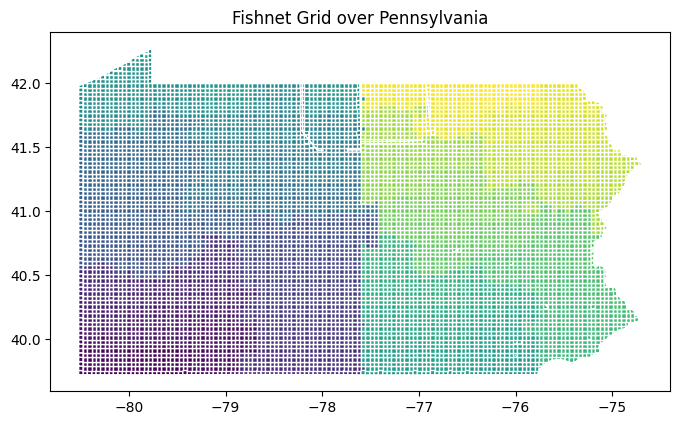

In [ ]:
# Visualize Fishnet
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Fishnet Grid over Pennsylvania')
pa_fishnet.plot(ax=ax, cmap='viridis', edgecolor='white')
plt.show()

### Load Processed Fishnet Data Below (Optional)

Alternatively, you may also load in the `pa_fishnet` file directly from our GitHub repository to save time.

In [9]:
pa_fishnet = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/pa_fishnet.geojson')

## **3. Remote Sensing Data**

We acquired all Landsat 8 level 2 images satellite images from Spring 2022 to Spring 2023 over the study area. These images were obtained via the Google Earth Engine API and are coded in the Earth Engine Data Catalog as [USGS Landsat 8 Level 2, Collection 2, Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#description). We acquired those images by season and took the average before further processing.

This specific version and level of processing of Landsat 8 satellite imagery provided by the United States Geological Survey uses Surface Reflectance Code to generate products with geometrical, radiometric, and atmospheric corrections. These products have a spatial resolution of 30 m. The products used in this study as predictors are the **surface reflectance OLI bands**,  **brightness temperature (BT)**, and some pre-processed indexes, such as the **normalized difference vegetation index (NDVI)**, **the soil-adjusted vegetation index (SAVI)**, and the **enhanced vegetation index (EVI)**. Moreover, the images were processed to scale alll the bands and remove cloud coverage.

Let's first set up the constants that define the temporal extent of our study and transform them into a format that Earth Engine expects.

In [ ]:
## Define Time Period
startSpring = datetime(2022, 3, 1) # spring
endSpring = datetime(2022, 5, 31)
startSummer = datetime(2022, 6, 1) # summer
endSummer = datetime(2022, 8, 31)
startFall = datetime(2022, 9, 1) # fall
endFall = datetime(2022, 11, 30)
startWinter = datetime(2022, 12, 1) # winter
endWinter = datetime(2023, 2, 28)

# Format dates into strings that Earth Engine expects ("YYYY-MM-DD")
startSpring= startSpring.strftime('%Y-%m-%d')
endSpring = endSpring.strftime('%Y-%m-%d')
startSummer = startSummer.strftime('%Y-%m-%d')
endSummer = endSummer.strftime('%Y-%m-%d')
startFall = startFall.strftime('%Y-%m-%d')
endFall = endFall.strftime('%Y-%m-%d')
startWinter = startWinter.strftime('%Y-%m-%d')
endWinter = endWinter.strftime('%Y-%m-%d')

The function `apply_scale_factors` applies scale and offset adjustments to Landsat satellite imagery bands, specifically for optical and thermal bands. In the Landsat data, pixel values are often represented as digital numbers (DN) which require conversion to physical units like reflectance or temperature.

In [ ]:
## Helper Function - Scale Bands
def apply_scale_factors(image):
    # Scale and offset values for optical bands
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Scale and offset values for thermal bands
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

    # Add scaled bands to the original image
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True)

The `cloud_mask function` is designed to create a binary mask for identifying and masking out pixels affected by clouds and cloud shadows in Landsat satellite imagery. It plays a crucial role in pre-processing Landsat imagery by removing cloud and cloud shadow effects to enhance data quality and reliability for downstream analysis.



In [ ]:
## Helper Function - Mask Clouds
def cloud_mask(image):
    # Define cloud shadow and cloud bitmask (Bits 3 and 5)
    cloud_shadow_bit_mask = 1 << 3
    cloud_bit_mask = 1 << 5

    # Select the Quality Assessment (QA) band for pixel quality information
    qa = image.select('QA_PIXEL')

    # Create a binary mask to identify clear conditions (both cloud and cloud shadow bits set to 0)
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
                .And(qa.bitwiseAnd(cloud_bit_mask).eq(0))

    # Update the original image, masking out cloud and cloud shadow-affected pixels
    return image.updateMask(mask)

### **3.1 Prepare Spring Data**

This section below documents our process of loading a springtime image collection from the Landsat 8 Level 2, Collection 2, Tier 1 dataset using the Google Earth Engine (GEE) Python API, aggregating the data into the fishnet, and joining them all together into one dataframe.

The code snippet loads spring season image series, applies scale factors and cloud masking, calculates a median composite image, and clips it to the specified area of interest, preparing the data for further analysis.


In [ ]:
## Load Spring Image Collection
imageSpring = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startSpring, endSpring) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

The `geemap` package allows us to visualize the median of all satellite images library from March 2022 to may 2022.

In [ ]:
## Visualize Spring Image Collection
Map = geemap.Map()
Map.addLayer(aoi, {}, 'AOI')
Map.centerObject(aoi, 10)

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.15,
}
Map.addLayer(imageSpring, visualization, 'True Color 432')
Map

As we breifly mentioned in the introduction, we acquired four different indices based on the bands of our satellite images. They are NDVI, SAVI, EVI, and LST. This code segment calculates the Normalized Difference Vegetation Index (NDVI) for the spring image collection. NDVI is a common vegetation index used to assess the presence and health of vegetation based on the difference in reflectance between near-infrared (NIR) and red light wavelengths.

The formula is ` NDVI = (Band 5 – Band 4) / (Band 5 + Band 4)`

In [ ]:
## Calculate Normalized Difference Vegetation Index (NDVI)
ndvi_spring = imageSpring.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

We may view the metadata information for the `ndvi_spring` image, including properties such as band names, data type, projection, scale, and other relevant information about the image computed from the NDVI calculation.







In [11]:
ndvi_spring.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDVI',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

This code computes the Soil Adjusted Vegetation Index (SAVI) for the spring image collection. SAVI is a vegetation index similar to NDVI but incorporates a soil brightness correction factor to account for variations in soil reflectance.

The formula is `SAVI = ((Band 5 – Band 4) / (Band 5 + Band 4 + 0.5)) * (1.5)`

In [ ]:
## Compute Soil Adjusted Vegetation Index (SAVI)
savi_spring = imageSpring.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageSpring.select('SR_B5'),
            'RED': imageSpring.select('SR_B4')
        }
    ).rename('SAVI')

This code computes the Enhanced Vegetation Index (EVI) for the spring image collection. EVI is a vegetation index designed to minimize the influence of atmospheric conditions and background noise on vegetation assessments.

The formula is: `EVI = 2.5 * ((Band 5 – Band 4) / (Band 5 + 6 * Band 4 – 7.5 * Band 2 + 1))`

In [ ]:
## Calculate Enhanced Vegetation Index (EVI)
evi_spring = imageSpring.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageSpring.select('SR_B5'),  # Near-Infrared (NIR) band
        'RED': imageSpring.select('SR_B4'),  # Red band
        'BLUE': imageSpring.select('SR_B2')  # Blue band
    }).rename('EVI')

Finally, we need to calculate the land surface temperature, which is broken down into several steps.
- **Minimum and Maximum NDVI Calculation**: It calculates the minimum and maximum NDVI values within the AOI using the `reduceRegion()` method. The reducer parameter specifies the type of aggregation (in this case, `min()` and `max()`)
- **Fraction of Vegetation (FV) Calculation**: It computes the Fraction of Vegetation (FV) using the `NDVI` values, `NDVI_min`, and `NDVI_max` obtained in the previous step. The formula calculates the square of the normalized difference between `NDVI` and `NDVI_min` divided by the difference between `NDVI_max` and `NDVI_min`.
- **Emissivity (EM) Calculation**: It calculates the emissivity using the `FV` values obtained from the previous step. The formula computes the emissivity based on the FV values according to the provided equation.
- **Land Surface Temperature (LST)** Calculation: It computes the Land Surface Temperature (LST) using the thermal band (Band 10) from the Landsat imagery and the emissivity values calculated earlier. The formula calculates the LST based on the Planck's Law, considering the thermal band as temperature in Kelvin and the calculated emissivity.

In [ ]:
## Compute the Land Surface Temperature

# Calculate the minimum and maximum NDVI values within the AOI
ndvi_min = ndvi_spring.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')

ndvi_max = ndvi_spring.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')

# Convert NDVI_min and NDVI_max to ee.Number for operations
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)

# Fraction of Vegetation (FV) Calculation
# Formula: ((NDVI - NDVI_min) / (NDVI_max - NDVI_min))^2
fv = ndvi_spring.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')

# Emissivity Calculation
# Formula: 0.004 * FV + 0.986
em = fv.multiply(0.004).add(0.986).rename('EM')

# Select Thermal Band (Band 10) and Rename It
thermal = imageSpring.select('ST_B10').rename('thermal')

lst_spring = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),  # Thermal band as the temperature in Kelvin
        'em': em  # Emissivity
    }
).rename('LST')

In addition to these indices, we will also include the bands into our model. We could get them from simply selecting bands from the spring image series.

In [ ]:
## Get Individual Band Information
band1_spring = imageSpring.select('SR_B1').rename('B1')
band2_spring = imageSpring.select('SR_B2').rename('B2')
band3_spring = imageSpring.select('SR_B3').rename('B3')
band4_spring = imageSpring.select('SR_B4').rename('B4')
band5_spring = imageSpring.select('SR_B5').rename('B5')
band6_spring = imageSpring.select('SR_B6').rename('B6')
band7_spring = imageSpring.select('SR_B7').rename('B7')

We summarized remote sensing data into the fishnet using zonal statistics. This is one of the easiest method of brining raster information into vector geometries. In Earth Engine, zonal statistics can be calculated by aggregating pixel values within geometries defined by feature collections (in our case, the fishnet). Common summary statistics computed for each zone include mean, sum, minimum, maximum, standard deviation, and percentile values (in our case, we will calculate the mean).


In [ ]:
## Helper Function - Zonal Statistics
def export_zonal_stats(image, reducer, index_name):
    zonal_stats = image.reduceRegions(
        collection=pa_fishnet_ee,
        reducer=reducer,
        scale=30
    )

    task = ee.batch.Export.table.toDrive(
        collection=zonal_stats,
        description=index_name,
        fileFormat='CSV',
        folder='remote-sensing' # default to our shared google drive for the project
    )
    task.start()

We wrote the export zonal statistics function and by default, it will write the output directly to google drive by default. If you would like to reproduce our result, please directly load the results or set up connections to your own google drive and create a new folder in it named `remote-sensing`.

In [ ]:
## Apply Zonal Statistics
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
reducer = ee.Reducer.mean()
pa_fishnet_ee = geemap.geopandas_to_ee(pa_fishnet)
indices = {
    'ndvi_spring': ndvi_spring,
    'evi_spring': evi_spring,
    'lst_spring': lst_spring,
    'savi_spring': savi_spring,
    'band1_spring': band1_spring,
    'band2_spring': band2_spring,
    'band3_spring': band3_spring,
    'band4_spring': band4_spring,
    'band5_spring': band5_spring,
    'band6_spring': band6_spring,
    'band7_spring': band7_spring
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_spring.csv')
evi_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_spring.csv')
savi_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_spring.csv')
lst_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_spring.csv')
band1_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_spring.csv')
band2_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_spring.csv')
band3_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_spring.csv')
band4_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_spring.csv')
band5_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_spring.csv')
band6_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_spring.csv')
band7_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_spring.csv')

We may see that the code above will give us 11 csv separate csv files, each with three columns. The `system:index` is a unique identifier for each fishnet, the `mean` is the mean pixels values, the `.geo` is the geometry of each fishnet. Our next taks is to join the 11 files together and covert it into a GeoDataFrame.

In [13]:
ndvi_spring_df.head()

,system:index,mean,.geo
0,0,0.582499,"{""type"":""Polygon"",""coordinates"":[[[-79.6210697..."
1,1,0.560937,"{""type"":""Polygon"",""coordinates"":[[[-79.5312382..."
2,2,0.613952,"{""type"":""Polygon"",""coordinates"":[[[-79.5761540..."
3,3,0.555680,"{""type"":""Polygon"",""coordinates"":[[[-79.4863225..."
4,4,0.547725,"{""type"":""Polygon"",""coordinates"":[[[-79.4414067..."


The joining of dataframes can be divided into the following parts:

- Create a list of `spring_dfs` containing the name of the dataframes ready to be join.
- Select a DataFrame to being the merge.
- Iterates over the remaining DataFrames in the list `spring_dfs` and merges them into the starting DataFrame. During the merge, it renames the mean column of each DataFrame to include the index name (e.g., evi_mean, savi_mean) and combines them based on a common key ('system:index').
- Some additional editing of the final dataframe include renaming the column to include the corresponding index name, converting geometry to a shapely geometry object, and writing the GeoDataFrame.


In [ ]:
## Combine Spring Dataframes
spring_dfs = [ndvi_spring_df,
       evi_spring_df,
       savi_spring_df,
       lst_spring_df,
       band1_spring_df,
       band2_spring_df,
       band3_spring_df,
       band4_spring_df,
       band5_spring_df,
       band6_spring_df,
       band7_spring_df]

# starting dataframe
spring_final = spring_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

# merge the rest of the dataframes to the starting dataframe
for df, name in zip(spring_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"  # Form the new column name
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    spring_final = pd.merge(spring_final, df, on='system:index', how='left')

spring_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
spring_final.rename(columns={'system:index': 'NetID'}, inplace=True)
spring_final['geometry'] = spring_final['.geo'].apply(lambda x: shape(json.loads(x)))
spring_final_geom = gpd.GeoDataFrame(spring_final, geometry='geometry')

Let's check the output of our merge.

In [ ]:
## Check Data
spring_final.head()

,NetID,ndvi_mean,.geo,evi_mean,savi_mean,lst_mean,band1_mean,band2_mean,band3_mean,band4_mean,band5_mean,band6_mean,band7_mean,geometry
0,0,0.582499,"{""type"":""Polygon"",""coordinates"":[[[-79.6210697...",0.317203,0.319262,17.863170,0.029108,0.034328,0.058367,0.061290,0.233169,0.214483,0.130735,POLYGON ((-79.62106979445613 39.75439960369839...
1,1,0.560937,"{""type"":""Polygon"",""coordinates"":[[[-79.5312382...",0.329028,0.331427,23.108124,0.031836,0.039398,0.067888,0.075006,0.260516,0.243111,0.149953,POLYGON ((-79.53123826604418 39.75439960369839...
2,2,0.613952,"{""type"":""Polygon"",""coordinates"":[[[-79.5761540...",0.327202,0.332131,19.105744,0.025416,0.029897,0.054197,0.054988,0.230909,0.201132,0.116945,POLYGON ((-79.57615403025017 39.75439960369839...
3,3,0.555680,"{""type"":""Polygon"",""coordinates"":[[[-79.4863225...",0.326954,0.329579,21.033911,0.030800,0.038006,0.064880,0.073164,0.258100,0.240018,0.149894,POLYGON ((-79.48632250183822 39.75439960369839...
4,4,0.547725,"{""type"":""Polygon"",""coordinates"":[[[-79.4414067...",0.303537,0.305277,19.811644,0.028708,0.034169,0.058865,0.060915,0.226415,0.215652,0.132315,POLYGON ((-79.44140673763222 39.75439960369839...


We could also visualize all the variables we have so far for using our processed spring data. We may see that the ndvi (as well as two other vegetation indices) are higher in the southeastern and southwestern part of the state but lower in the central part of the state.

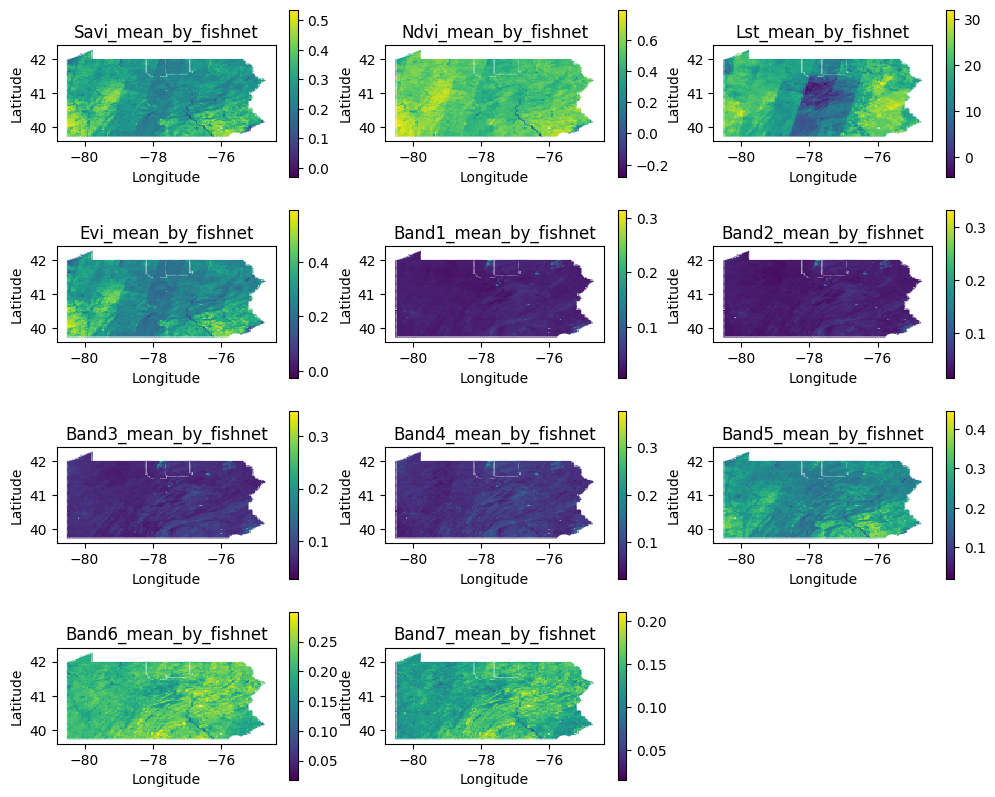

In [ ]:
## Visualizing Variables for Spring
columns_to_plot = ['savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band2_mean', 'band3_mean', 'band4_mean', 'band5_mean', 'band6_mean', 'band7_mean']

num_plots = len(columns_to_plot)
num_cols = 3  #
num_rows = num_plots // num_cols + (1 if num_plots % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
if num_rows > 1:
    axes = axes.flatten()

# Loop over the columns and plot each variable as small multiples
for i, column in enumerate(columns_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols
    spring_final_geom.plot(column=column, cmap='viridis', legend=True, ax=axes[i])

    axes[i].set_title(f'{column.capitalize()}_by_fishnet')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')

# Remove empty subplots if necessary
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.show()


### **3.2 Prepare Summer Data**

Now, we will repeate the exact same processing steps for the summer data.

In [ ]:
imageSummer = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startSummer, endSummer) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
ndvi_summer = imageSummer.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
savi_summer = imageSummer.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageSummer.select('SR_B5'),
            'RED': imageSummer.select('SR_B4')
        }
    ).rename('SAVI')
evi_summer = imageSummer.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageSummer.select('SR_B5'),
        'RED': imageSummer.select('SR_B4'),
        'BLUE': imageSummer.select('SR_B2')
    }).rename('EVI')
ndvi_min = ndvi_summer.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_max = ndvi_summer.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)
fv = ndvi_summer.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = imageSummer.select('ST_B10').rename('thermal')
lst_summer = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),
        'em': em
    }
).rename('LST')

In [ ]:
band1_summer = imageSummer.select('SR_B1').rename('B1')
band2_summer = imageSummer.select('SR_B2').rename('B2')
band3_summer = imageSummer.select('SR_B3').rename('B3')
band4_summer = imageSummer.select('SR_B4').rename('B4')
band5_summer = imageSummer.select('SR_B5').rename('B5')
band6_summer = imageSummer.select('SR_B6').rename('B6')
band7_summer = imageSummer.select('SR_B7').rename('B7')

In [ ]:
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
indices = {
    'ndvi_summer': ndvi_summer,
    'evi_summer': evi_summer,
    'lst_summer': lst_summer,
    'savi_summer': savi_summer,
    'band1_summer': band1_summer,
    'band2_summer': band2_summer,
    'band3_summer': band3_summer,
    'band4_summer': band4_summer,
    'band5_summer': band5_summer,
    'band6_summer': band6_summer,
    'band7_summer': band7_summer
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_summer.csv')
evi_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_summer.csv')
savi_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_summer.csv')
lst_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_summer.csv')
band1_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_summer.csv')
band2_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_summer.csv')
band3_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_summer.csv')
band4_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_summer.csv')
band5_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_summer.csv')
band6_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_summer.csv')
band7_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_summer.csv')

In [ ]:
summer_dfs = [ndvi_summer_df,
       evi_summer_df,
       savi_summer_df,
       lst_summer_df,
       band1_summer_df,
       band2_summer_df,
       band3_summer_df,
       band4_summer_df,
       band5_summer_df,
       band6_summer_df,
       band7_summer_df]
summer_final = summer_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

for df, name in zip(summer_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    summer_final = pd.merge(summer_final, df, on='system:index', how='left')

summer_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
summer_final.rename(columns={'system:index': 'NetID'}, inplace=True)
summer_final['geometry'] = summer_final['.geo'].apply(lambda x: shape(json.loads(x)))
summer_final_geom = gpd.GeoDataFrame(summer_final, geometry='geometry')

### **3.3 Prepare Fall Data**

Now, we will repeate the exact same processing steps for the fall data.

In [ ]:
imageFall = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startFall, endFall) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
ndvi_fall = imageFall.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
savi_fall = imageFall.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageFall.select('SR_B5'),
            'RED': imageFall.select('SR_B4')
        }
    ).rename('SAVI')
evi_fall = imageFall.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageFall.select('SR_B5'),
        'RED': imageFall.select('SR_B4'),
        'BLUE': imageFall.select('SR_B2')
    }).rename('EVI')
ndvi_min = ndvi_fall.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_max = ndvi_fall.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)
fv = ndvi_fall.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = imageFall.select('ST_B10').rename('thermal')
lst_fall = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),
        'em': em
    }
).rename('LST')

In [ ]:
band1_fall = imageFall.select('SR_B1').rename('B1')
band2_fall = imageFall.select('SR_B2').rename('B2')
band3_fall = imageFall.select('SR_B3').rename('B3')
band4_fall = imageFall.select('SR_B4').rename('B4')
band5_fall = imageFall.select('SR_B5').rename('B5')
band6_fall = imageFall.select('SR_B6').rename('B6')
band7_fall = imageFall.select('SR_B7').rename('B7')

In [ ]:
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
indices = {
    'ndvi_fall': ndvi_fall,
    'evi_fall': evi_fall,
    'lst_fall': lst_fall,
    'savi_fall': savi_fall,
    'band1_fall': band1_fall,
    'band2_fall': band2_fall,
    'band3_fall': band3_fall,
    'band4_fall': band4_fall,
    'band5_fall': band5_fall,
    'band6_fall': band6_fall,
    'band7_fall': band7_fall
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_fall.csv')
evi_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_fall.csv')
savi_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_fall.csv')
lst_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_fall.csv')
band1_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_fall.csv')
band2_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_fall.csv')
band3_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_fall.csv')
band4_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_fall.csv')
band5_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_fall.csv')
band6_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_fall.csv')
band7_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_fall.csv')

In [ ]:
fall_dfs = [ndvi_fall_df,
       evi_fall_df,
       savi_fall_df,
       lst_fall_df,
       band1_fall_df,
       band2_fall_df,
       band3_fall_df,
       band4_fall_df,
       band5_fall_df,
       band6_fall_df,
       band7_fall_df]
fall_final = fall_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

for df, name in zip(fall_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    fall_final = pd.merge(fall_final, df, on='system:index', how='left')

fall_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
fall_final.rename(columns={'system:index': 'NetID'}, inplace=True)
fall_final['geometry'] = fall_final['.geo'].apply(lambda x: shape(json.loads(x)))
fall_final_geom = gpd.GeoDataFrame(fall_final, geometry='geometry')

### **3.4 Prepare Winter Data**

Now, we will repeate the exact same processing steps for the winter data.

In [ ]:
imageWinter = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startWinter, endWinter) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
ndvi_winter = imageWinter.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
savi_winter = imageWinter.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageWinter.select('SR_B5'),
            'RED': imageWinter.select('SR_B4')
        }
    ).rename('SAVI')
evi_winter = imageWinter.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageWinter.select('SR_B5'),
        'RED': imageWinter.select('SR_B4'),
        'BLUE': imageWinter.select('SR_B2')
    }).rename('EVI')
ndvi_min = ndvi_winter.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_max = ndvi_winter.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)
fv = ndvi_winter.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = imageWinter.select('ST_B10').rename('thermal')
lst_winter = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),
        'em': em
    }
).rename('LST')

In [ ]:
band1_winter = imageWinter.select('SR_B1').rename('B1')
band2_winter = imageWinter.select('SR_B2').rename('B2')
band3_winter = imageWinter.select('SR_B3').rename('B3')
band4_winter = imageWinter.select('SR_B4').rename('B4')
band5_winter = imageWinter.select('SR_B5').rename('B5')
band6_winter = imageWinter.select('SR_B6').rename('B6')
band7_winter = imageWinter.select('SR_B7').rename('B7')

In [ ]:
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
indices = {
    'ndvi_winter': ndvi_winter,
    'evi_winter': evi_winter,
    'lst_winter': lst_winter,
    'savi_winter': savi_winter,
    'band1_winter': band1_winter,
    'band2_winter': band2_winter,
    'band3_winter': band3_winter,
    'band4_winter': band4_winter,
    'band5_winter': band5_winter,
    'band6_winter': band6_winter,
    'band7_winter': band7_winter
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_winter.csv')
evi_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_winter.csv')
savi_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_winter.csv')
lst_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_winter.csv')
band1_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_winter.csv')
band2_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_winter.csv')
band3_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_winter.csv')
band4_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_winter.csv')
band5_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_winter.csv')
band6_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_winter.csv')
band7_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_winter.csv')

In [ ]:
winter_dfs = [ndvi_winter_df,
       evi_winter_df,
       savi_winter_df,
       lst_winter_df,
       band1_winter_df,
       band2_winter_df,
       band3_winter_df,
       band4_winter_df,
       band5_winter_df,
       band6_winter_df,
       band7_winter_df]
winter_final = winter_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

for df, name in zip(winter_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    winter_final = pd.merge(winter_final, df, on='system:index', how='left')

winter_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
winter_final.rename(columns={'system:index': 'NetID'}, inplace=True)
winter_final['geometry'] = winter_final['.geo'].apply(lambda x: shape(json.loads(x)))
winter_final_geom = gpd.GeoDataFrame(winter_final, geometry='geometry')

### Load Processed Remote Sensing Data Below (Optional)


Alternatively, you may load the final products from this section directly from our Github repository.

In [45]:
## PLAIN TABULAR DATA
spring_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/spring_final.csv')
summer_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/summer_final.csv')
fall_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/fall_final.csv')
winter_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_final.csv')

## GEOJSON DATA
spring_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/spring_final_geom.geojson')
summer_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/summer_final_geom.geojson')
fall_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_final_geom.geojson')
winter_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_final_geom.geojson')

## **4. Hospital Discharge Data**

We downloaded the hospital discharge data from the Pennsylvania Department of Health's data dashboard. The [Enterprise Data Dissemination Informatics Exchange (EDDIE)](https://www.health.pa.gov/topics/HealthStatistics/EDDIE/Pages/EDDIE.aspx) is an interactive health statistics dissemination web tool where user create customized data tables, charts and maps for various health related data. We obtained hospitalization discharge due to chronic lower respiratory diseases only, of which the age-adjusted rates are standardized to the year 2000 US million population.

Since the raw hospital data is a plain CSV file, we need to first append county geometries to it by joining it with our PA geometries file, using county name as the match.

In [5]:
## Load Hospital Data
hospital_raw = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/HospitalizationDischarges.csv')
hospital_clean = hospital_raw[['Geography', 'Count', 'Geography_Code', 'Population']]
hospital_clean['Geography'] = hospital_clean['Geography'].str.lower()  # Convert values to lowercase

We may see that the raw hospital data does not contain any geometries, but the county name can be helpful for us to join it to the county geometries.

In [9]:
hospital_clean.head()

,Geography,Count,Geography_Code,Population
0,pennsylvania,"21,076",0,"12,972,008"
1,adams,110,1,"106,027"
2,allegheny,"1,664",3,"1,233,253"
3,armstrong,99,5,"64,747"
4,beaver,238,7,"165,677"


In [ ]:
## Clean State Boundary Data
pa_clean = pa[['fips_count', 'county_nam', 'geometry']]
pa_clean['Geography'] = pa_clean['county_nam'].str.lower()  # Convert values to lowercase
pa_clean = pa_clean.drop(columns=['county_nam'])

In [ ]:
county_discharge = pd.merge(pa_clean, hospital_clean, on='Geography', how='left')

After the join, the `county_discharge` data will look like the following.

In [14]:
county_discharge.head()

,fips_count,geometry,Geography,Count,Geography_Code,Population
0,091,"MULTIPOLYGON (((-75.04927 40.11219, -75.05431 ...",montgomery,"1,095",91,"864,683"
1,015,"MULTIPOLYGON (((-76.14569 41.99886, -76.14364 ...",bradford,127,15,"59,866"
2,017,"MULTIPOLYGON (((-75.19130 40.58571, -75.19157 ...",bucks,963,17,"645,054"
3,117,"MULTIPOLYGON (((-76.91122 41.58167, -76.91133 ...",tioga,63,117,"41,106"
4,119,"MULTIPOLYGON (((-76.91306 40.88455, -76.91356 ...",union,33,119,"42,744"


Through visualizing the hospital discharge of CRDs in Pennsylvania, we may see significant urban-rural differences in CRD risks. CRD hospitalization is much higher in Philadelphia and surrounding counties as well as in Pittsburgh. We may also see that CRD data is missing for one county.

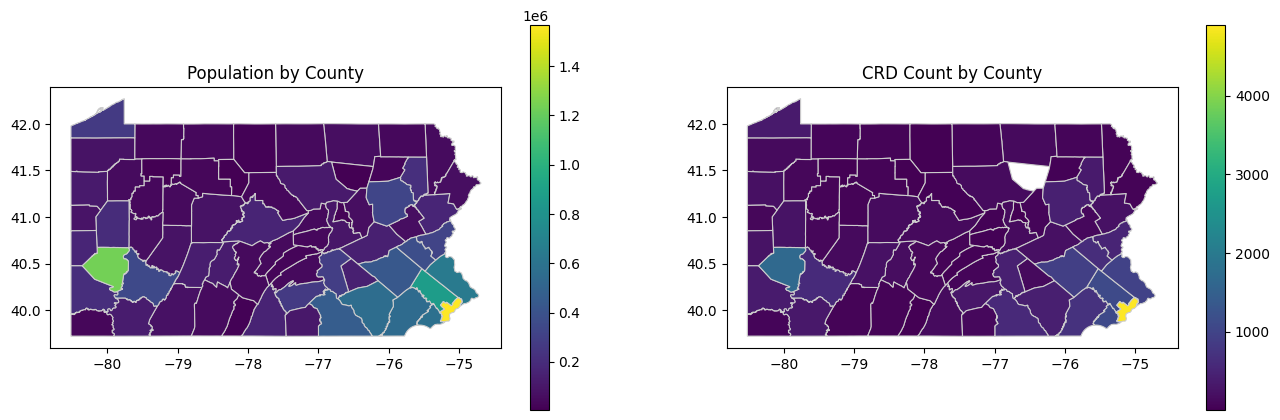

In [89]:
## Visualize Hospital Discharge Data
fig, axs = plt.subplots(1, 2, figsize=(16,5))

map = county_discharge.copy()

map['Population'] = map['Population'].str.replace(',', '')
map['Population'] = pd.to_numeric(map['Population'], errors='coerce')
map['Count'] = map['Count'].str.replace(',', '')
map['Count'] = pd.to_numeric(map['Count'], errors='coerce')


map.plot(column='Population', cmap='viridis', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True)
axs[0].set_title('Population by County')

map.plot(column='Count', cmap='viridis', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True)
axs[1].set_title('CRD Count by County')

plt.show()

### **4.1 Aggregate Hospital Data to Fishnet**

Having the hospital discharge data at the county is not very useful as our desired spatial unit of analysis is the fishnet. The workflow we've designed to aggregate hospital data to the fishnet is to first create a NetID (starting from zero) for each fishnet. Then, we create a centroid for each fishnet (fishpoint). Depending on which county each centroid falls into, we will append the name of the county and the corresponding hospital discharge to that fishnet grid. For visuaization purpose, we will join the fishpoint layer back to the fishnet polygon by the NetID.

In [10]:
## Prepare Fishpoint
id = len(pa_fishnet.index)
pa_fishnet['id'] = range(0, id)
fishpoint = pa_fishnet.copy()
fishpoint['centroid'] = fishpoint.geometry.centroid
fishpoint.drop(columns=['geometry'], inplace=True)
fishpoint.rename(columns={'centroid': 'geometry'}, inplace=True)

In [11]:
# if points fall within a county, give the name of the county, join with it
fishpoint_discharge = gpd.sjoin(fishpoint, county_discharge, how='left', op='intersects')
# bring points back to net
fishpoint_discharge.drop(columns=['geometry'], inplace=True)
fishnet_discharge = pd.merge(pa_fishnet, fishpoint_discharge, on='id', how='left')

Due to some the geometry errors of the Pennsylvanian state layer, there are in total five fishnet grids that failed to join with the county layer and hence recieve no CRD data. We will drop these entries before running the model.

In [101]:
# Find the rows where the "Count" column is null
null_rows = fishnet_discharge[fishnet_discharge['Count'].isnull()]
print(null_rows)

                                               geometry    id  index_right  \
4326  MULTIPOLYGON (((-80.11514 42.16226, -80.07840 ...  4326          NaN   
5926  MULTIPOLYGON (((-75.03966 40.40934, -75.03964 ...  5926          NaN   
6150  MULTIPOLYGON (((-75.08458 40.82862, -75.08452 ...  6150          NaN   
7283  POLYGON ((-74.99475 41.12175, -74.95051 41.121...  7283          NaN   
7988  MULTIPOLYGON (((-75.26424 41.86927, -75.26421 ...  7988          NaN   

     fips_count Geography Count  Geography_Code Population  
4326        NaN       NaN   NaN             NaN        NaN  
5926        NaN       NaN   NaN             NaN        NaN  
6150        NaN       NaN   NaN             NaN        NaN  
7283        NaN       NaN   NaN             NaN        NaN  
7988        NaN       NaN   NaN             NaN        NaN  


An additional step here is to normalize/scale the count of CRDs in each county to its total population. This can be achieved through calculating the CRD rate per thousand population.

In [12]:
fishnet_discharge['Count'] = fishnet_discharge['Count'].str.replace(',', '')
fishnet_discharge['Count'] = pd.to_numeric(fishnet_discharge['Count'], errors='coerce')
fishnet_discharge['Population'] = fishnet_discharge['Population'].str.replace(',', '')
fishnet_discharge['Population'] = pd.to_numeric(fishnet_discharge['Population'], errors='coerce')
fishnet_discharge['CRD_Rate'] = fishnet_discharge['Count'] / fishnet_discharge['Population'] * 1000

If we visualize hospitalization discharge of patient with CRD rate per thousand people this time instead of of the raw CRD count, we may see more variations in CRDs across different counties. A few counties in the northern and central part of Pennsylvania stand out as having higher CRD rate.

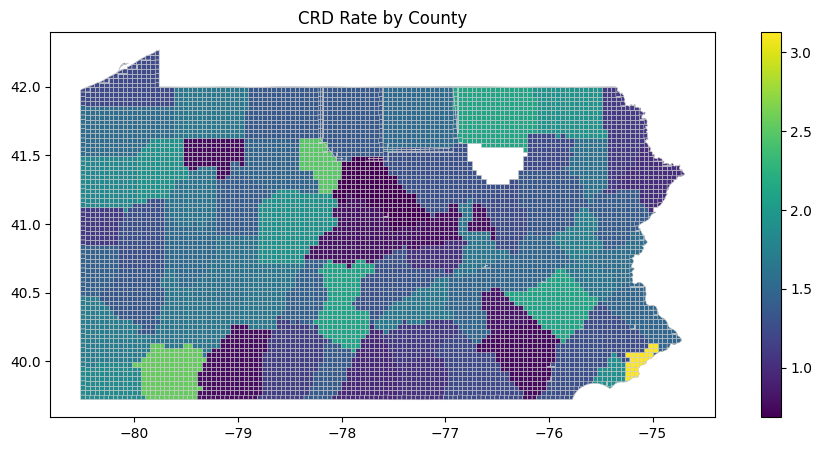

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
fishnet_discharge.plot(column='CRD_Rate', cmap='viridis', linewidth=0.4, ax=ax, edgecolor='0.8', legend=True)
plt.title('CRD Rate by County')
plt.show()

### **4.2 Combine Hospital Data and Remote Sensing Data**

We also need to combine hospital discharge with remote sensing data. This can be easily done with a simple join because we have created a NetID for both the remote sensing datasets and our fishnet that now contains hospital discharge data. To further makesure the IDs will match, we selected the first 400 fishnet grids from both datasets and have found the output to match each other. This means we can go for the join with no worry.

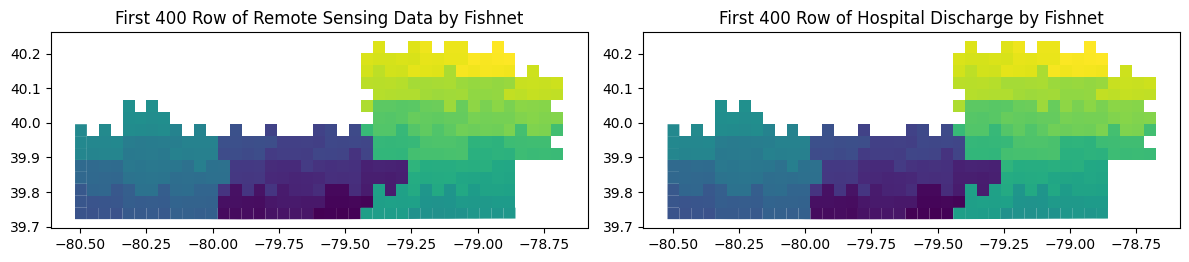

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
filtered_net = fishnet_discharge.head(400)
filtered_spring = spring_final_geom.head(400)

# Plot the filtered spring DataFrame in the first subplot
filtered_spring.plot(ax=axs[0], cmap='viridis')
axs[0].set_title('First 400 Row of Remote Sensing Data by Fishnet')

# Plot the filtered net DataFrame in the second subplot
filtered_net.plot(ax=axs[1], cmap='viridis')
axs[1].set_title('First 400 Row of Hospital Discharge by Fishnet')

# Show the plots
plt.tight_layout()
plt.show()

We will repeate the join four times, each for different season. We will also drop all grids without hospital discharge data. This includes the five grids that are not joined to the county as well as the entire county without CRD data. This gives us 8309 grids in total. Originally, there were 8397 grids.

In [38]:
spring_discharge_bynet = pd.merge(fishnet_discharge, spring_final, left_on='id', right_on='NetID', how='left')
spring_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)
summer_discharge_bynet = pd.merge(fishnet_discharge, summer_final, left_on='id', right_on='NetID', how='left')
summer_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)
fall_discharge_bynet = pd.merge(fishnet_discharge, fall_final, left_on='id', right_on='NetID', how='left')
fall_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)
winter_discharge_bynet = pd.merge(fishnet_discharge, winter_final, left_on='id', right_on='NetID', how='left')
winter_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)

Using the spring data as an exmaple, the joined dataset should look like the following.

In [106]:
spring_discharge_bynet.head()

,geometry_x,id,index_right,fips_count,Geography,Count,Geography_Code,Population,CRD_Rate,NetID,...,savi_mean,lst_mean,band1_mean,band2_mean,band3_mean,band4_mean,band5_mean,band6_mean,band7_mean,geometry_y
0,"POLYGON ((-79.62107 39.75440, -79.57615 39.754...",0,56.0,051,fayette,321.0,51.0,125755.0,2.552582,0,...,0.319262,17.863170,0.029108,0.034328,0.058367,0.061290,0.233169,0.214483,0.130735,POLYGON ((-79.62106979445613 39.75439960369839...
1,"POLYGON ((-79.53124 39.75440, -79.48632 39.754...",1,56.0,051,fayette,321.0,51.0,125755.0,2.552582,1,...,0.331427,23.108124,0.031836,0.039398,0.067888,0.075006,0.260516,0.243111,0.149953,POLYGON ((-79.53123826604418 39.75439960369839...
2,"POLYGON ((-79.57615 39.75440, -79.53124 39.754...",2,56.0,051,fayette,321.0,51.0,125755.0,2.552582,2,...,0.332131,19.105744,0.025416,0.029897,0.054197,0.054988,0.230909,0.201132,0.116945,POLYGON ((-79.57615403025017 39.75439960369839...
3,"POLYGON ((-79.48632 39.75440, -79.44141 39.754...",3,56.0,051,fayette,321.0,51.0,125755.0,2.552582,3,...,0.329579,21.033911,0.030800,0.038006,0.064880,0.073164,0.258100,0.240018,0.149894,POLYGON ((-79.48632250183822 39.75439960369839...
4,"POLYGON ((-79.44141 39.78892, -79.39649 39.788...",4,56.0,051,fayette,321.0,51.0,125755.0,2.552582,4,...,0.305277,19.811644,0.028708,0.034169,0.058865,0.060915,0.226415,0.215652,0.132315,POLYGON ((-79.44140673763222 39.75439960369839...


## **5. Air Quality Data**

Air quality data are usually collected through field measurements. In our project, this field data were obtained from the Ambient Air Monitoring Data Reports - [Monthly Parameter Detail Table](http://www.ahs2.dep.state.pa.us/aq_apps/aadata/Default.aspx). This is an officia app of the PA government that collects and calcualtes the mean of a variety of air quality indices by month. Because this app does not provide the location of these measuring sites, we obtained the location of measuring sites from this interactive [map](https://epa.maps.arcgis.com/apps/webappviewer/index.html?id=5f239fd3e72f424f98ef3d5def547eb5&extent=-146.2334,13.1913,-46.3896,56.5319).

One of the biggest challenges of processing the air quality data is that different air quality indices are collected by different stations. For example, one station collects PM2.5 and O3 but not NO2 and SO2, while the other station collects wind speed and solar radiation data. This means that we have to make unique spatial interpolation of the influence zone of each air quality indices, based on the location of the specific measuring sites that collec them. Therefore, for each kind of air quality indices that we collect, we computed their voronoi polygon respectively.

In the original paper, the authors have collected Wind speed (WS), Wind direction (WD), Precipitation (PR), carbon oxide (CO), PM2.5, PM10, SO2, O3, and NO2 data at each station, but in the state Pennsylvania, air quality data is much less complete. This leads to our second biggest challenges, determining the air quality indices to collect. After carefully examining the completeness of data, we eventually selected **PM2.5, O3, Solar Radiation, and Wind Speed** as indices to include. These are the top four indices with the most number of stations collect them in Pennsylvania. The more stations collecting these data, the more accurate our spatial interpolation will be because our voronoi polygon will better capture the intra-regional variations in air quality measures. There are some occurences of missing data, but this will not significantly impact our analysis.

With these in mind, we downloaded the monthly average measures of these four indices for each of their stations, average them by season, and join the locations of these stations to the dataframe.

### **5.1 Process and Aggregate PM2.5 Data**

We begin processing the air quality data by first constructing geometries for it based on the longitude and latitude of the station locations. After that, we need to make sure it has the same projection as our other datasets.

In [ ]:
pm25_raw = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/AQ-Data-PM25.csv')
pm25_geom = gpd.GeoDataFrame(pm25_raw, geometry=gpd.points_from_xy(pm25_raw['Longitude'], pm25_raw['Latitude']))
pm25_geom.crs = {'init': 'epsg:4326'}

Belows is the helper function that takes a Voronoi diagram in 2D as input and reconstructs the infinite Voronoi regions into finite regions. The function is adapted from this GitHub [post](https://gist.github.com/Sklavit/e05f0b61cb12ac781c93442fbea4fb55).

It can be broken down to the following components, as documented by the function author:

- Input Validation: It checks if the input Voronoi diagram is in 2D.
- Initialization: It initializes empty lists to store the new regions and vertices.
- Center and Radius Calculation: It calculates the center of the diagram and, if not provided, determines a suitable radius based on the maximum point-to-point distance.
- Ridge Mapping: It constructs a map that contains all ridges for each point in the diagram.
- Region Reconstruction: It iterates through each point in the original Voronoi diagram and its corresponding region.
- Handling Finite Regions: If a region is finite (i.e., all vertices have non-negative indices), it adds the vertices directly to the new regions.
- Handling Non-finite Regions: If a region is non-finite (i.e., contains vertices with negative indices indicating they are part of infinite ridges), it reconstructs the missing vertices at infinity.
- Computing Infinite Ridge Endpoints: It computes the missing endpoint of each infinite ridge by determining the direction from the midpoint of the ridge towards the outer boundary, then extending it by the specified radius.
Sorting Vertices: It sorts the vertices of each region in counterclockwise order.
- Finishing Up: It appends the reconstructed region to the list of new regions.
Return: It returns the lists of revised regions and vertices.

Ultimately, this function reconstructs infinite Voronoi regions into finite ones, effectively handling edge cases where the diagram extends infinitely. The function returns `regions`, which contains the indices of the vertices in each revised Voronoi region, and `vertices`, which contains the coordinates for the revised Voronoi vertices.


In [ ]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

We took the point coordinates of our PM2.5 dataframe, and generates a Voronoi diagram `vor_pm25`. The Voronoi diagram creates regions where each point in a region is closer to its associated data point than to any other data point. Then our function reconstructs infinite Voronoi regions into finite ones.

In [ ]:
pm25_coords = np.column_stack((pm25_geom.geometry.x, pm25_geom.geometry.y))
vor_pm25 = Voronoi(pm25_coords)
regions_pm25, vertices_pm25 = voronoi_finite_polygons_2d(vor_pm25)

Below is a quick visualization of the voronoi polygons of PM2.5 measuring stations in Pennsylvania.

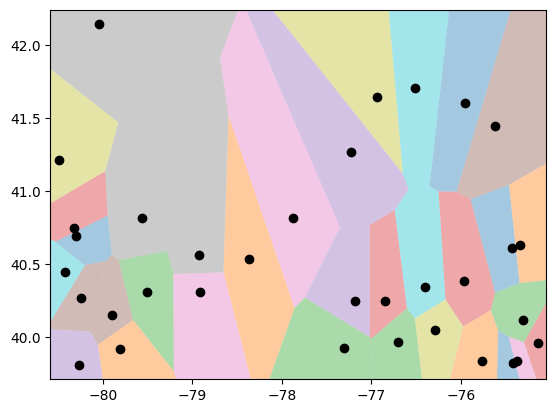

In [21]:
for region in regions_pm25:
    polygon = vertices_pm25[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(pm25_coords[:,0], pm25_coords[:,1], 'ko')
plt.xlim(vor_pm25.min_bound[0] - 0.1, vor_pm25.max_bound[0] + 0.1)
plt.ylim(vor_pm25.min_bound[1] - 0.1, vor_pm25.max_bound[1] + 0.1)

plt.show()

We need to clip our voronoi polygons to the spatial extent of Pennsylvania. This can be achieved by iterating through the voronoi regions and then for each region, retrieves the corresponding vertices and constructs a polygon using these vertices. Then, clip each polygon with PA boundary. If the clipped polygon resulting from the intersection is empty, indicating no overlap with the boundary, it skips to the next iteration.


In [ ]:
clipped_voronoi_polygons = []
for region in regions_pm25:
    polygon = vertices_pm25[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

# Create a GeoDataFrame from the list of clipped Voronoi polygons
voronoi_pm25 = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)

In [34]:
voronoi_pm25.head()

,geometry
0,"POLYGON ((-75.46131 41.04261, -75.34256 40.369..."
1,"POLYGON ((-78.65090 40.44175, -78.59594 41.517..."
2,"POLYGON ((-76.98808 39.72000, -76.99506 39.719..."
3,"POLYGON ((-79.97194 41.13585, -79.94506 40.831..."
4,"POLYGON ((-77.74339 40.27050, -77.35083 40.750..."


Because the output dataframe from the clipping operation only contains the geometry of the polygon, we need to join station information to it. This can be achieved through making an intersection between the polygons and the point of the stations.

In [ ]:
voronoi_pm25_geom = gpd.sjoin(voronoi_pm25,pm25_geom, op='intersects')
voronoi_pm25_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [36]:
voronoi_pm25_geom.head()

,geometry,StationName,CountyName,Spring,Summer,Fall,Winter
0,"POLYGON ((-75.46131 41.04261, -75.34256 40.369...",Allentown,Lehigh,7.27,8.07,7.07,9.80
1,"POLYGON ((-78.65090 40.44175, -78.59594 41.517...",Altoona,Blair,7.07,8.03,7.53,9.67
2,"POLYGON ((-76.98808 39.72000, -76.99506 39.719...",Arendtsville,Adams,7.57,8.73,7.50,9.80
3,"POLYGON ((-79.97194 41.13585, -79.94506 40.831...",Beaver Falls,Beaver,8.50,10.83,9.67,11.40
4,"POLYGON ((-77.74339 40.27050, -77.35083 40.750...",Carlisle,Cumberland,7.63,8.47,8.30,11.47


The following code joins the fishpoint to voronoi polygon if the point intersect with the polygon. This is followed by brining the fishpoint (now with PM2.5 information) to the fishnet polygons.

In [ ]:
fishpoint_vor_pm25 = gpd.sjoin(fishpoint, voronoi_pm25_geom, how='left', op='intersects')
fishpoint_vor_pm25.drop(columns=['geometry'], inplace=True)
fishnet_pm25 = pd.merge(pa_fishnet, fishpoint_vor_pm25, on='id', how='left')

Now that the data is at the scale of fishnet, let's join it with the remote sensing data. We will repeate that for each season. Some additional processing steps, such as renaming and dropping columns, are needed for the successful join.

In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_pm25[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_pm25[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_pm25[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_pm25[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'PM25'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'PM25'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'PM25'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'PM25'}, inplace=True)

In [ ]:
spring_discharge_bynet.drop(columns=['geometry_y'], inplace=True)
summer_discharge_bynet.drop(columns=['geometry_y'], inplace=True)
fall_discharge_bynet.drop(columns=['geometry_y'], inplace=True)
winter_discharge_bynet.drop(columns=['geometry_y'], inplace=True)

As an example, this is how our joined dataset should look like at this point.

In [44]:
spring_discharge_bynet.head()

,geometry_x,id,index_right,fips_count,Geography,Count,Geography_Code,Population,CRD_Rate,NetID,...,savi_mean,lst_mean,band1_mean,band2_mean,band3_mean,band4_mean,band5_mean,band6_mean,band7_mean,PM25
0,"POLYGON ((-79.62107 39.75440, -79.57615 39.754...",0,56.0,051,fayette,321.0,51.0,125755.0,2.552582,0,...,0.319262,17.863170,0.029108,0.034328,0.058367,0.061290,0.233169,0.214483,0.130735,7.0
1,"POLYGON ((-79.53124 39.75440, -79.48632 39.754...",1,56.0,051,fayette,321.0,51.0,125755.0,2.552582,1,...,0.331427,23.108124,0.031836,0.039398,0.067888,0.075006,0.260516,0.243111,0.149953,7.0
2,"POLYGON ((-79.57615 39.75440, -79.53124 39.754...",2,56.0,051,fayette,321.0,51.0,125755.0,2.552582,2,...,0.332131,19.105744,0.025416,0.029897,0.054197,0.054988,0.230909,0.201132,0.116945,7.0
3,"POLYGON ((-79.48632 39.75440, -79.44141 39.754...",3,56.0,051,fayette,321.0,51.0,125755.0,2.552582,3,...,0.329579,21.033911,0.030800,0.038006,0.064880,0.073164,0.258100,0.240018,0.149894,7.0
4,"POLYGON ((-79.44141 39.78892, -79.39649 39.788...",4,56.0,051,fayette,321.0,51.0,125755.0,2.552582,4,...,0.305277,19.811644,0.028708,0.034169,0.058865,0.060915,0.226415,0.215652,0.132315,7.0


The visualization belows shows the voronoi polygon, the fishnet, and the PM2.5 level for each season in Pennsylvania. We may see that PM2.5 tends to be higher in winter and summer while lower in spring and fall. Some counties in particular, stand out as having much higher PM2.5 than others.

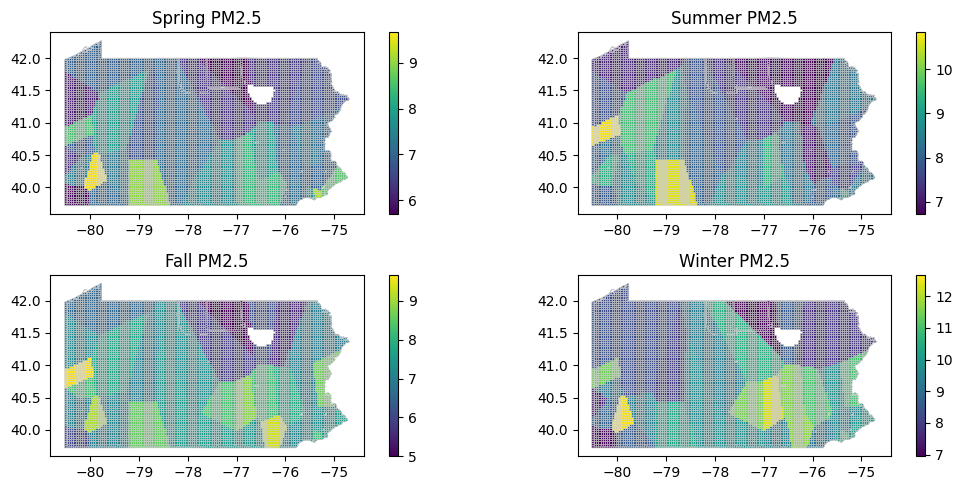

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(11, 5))

spring_discharge_bynet.rename(columns={'geometry_x': 'geometry'}, inplace=True)
summer_discharge_bynet.rename(columns={'geometry_x': 'geometry'}, inplace=True)
fall_discharge_bynet.rename(columns={'geometry_x': 'geometry'}, inplace=True)
winter_discharge_bynet.rename(columns={'geometry_x': 'geometry'}, inplace=True)

# Plot PM2.5 levels at fishnet for each subplot
spring_discharge_bynet.plot(column='PM25', cmap='viridis', linewidth=0.4, ax=axes[0, 0], edgecolor='0.8', legend=True)
summer_discharge_bynet.plot(column='PM25', cmap='viridis', linewidth=0.4, ax=axes[0, 1], edgecolor='0.8', legend=True)
fall_discharge_bynet.plot(column='PM25', cmap='viridis', linewidth=0.4, ax=axes[1, 0], edgecolor='0.8', legend=True)
winter_discharge_bynet.plot(column='PM25', cmap='viridis', linewidth=0.4, ax=axes[1, 1], edgecolor='0.8', legend=True)

# Set titles for each subplot
axes[0, 0].set_title('Spring PM2.5')
axes[0, 1].set_title('Summer PM2.5')
axes[1, 0].set_title('Fall PM2.5')
axes[1, 1].set_title('Winter PM2.5')

# Adjust layout
plt.tight_layout()
plt.show()

### **5.2 Process and Aggregate O3 Data**

We will repeate the exact same process to read and process the O3 data. Note that we have to construct separate voronoi polygons for O3 because the stations collecting O3 data is different from those collecting PM2.5

In [ ]:
o3_raw = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/AQ-Data-O3.csv')
o3_geom = gpd.GeoDataFrame(o3_raw, geometry=gpd.points_from_xy(o3_raw['Longitude'], o3_raw['Latitude']))
o3_geom.crs = {'init': 'epsg:4326'}

In [ ]:
o3_coords = np.column_stack((o3_geom.geometry.x, o3_geom.geometry.y))
vor_o3 = Voronoi(o3_coords)
regions_o3, vertices_o3 = voronoi_finite_polygons_2d(vor_o3)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_o3:
    polygon = vertices_o3[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

voronoi_o3 = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)

In [ ]:
voronoi_o3_geom = gpd.sjoin(voronoi_o3,o3_geom, op='intersects')
voronoi_o3_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [29]:
fishpoint_vor_o3 = gpd.sjoin(fishpoint, voronoi_o3_geom, how='left', op='intersects')
fishpoint_vor_o3.drop(columns=['geometry'], inplace=True)
fishnet_o3 = pd.merge(pa_fishnet, fishpoint_vor_o3, on='id', how='left')

In [30]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_o3[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_o3[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_o3[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_o3[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [31]:
spring_discharge_bynet.rename(columns={'Spring': 'O3'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'O3'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'O3'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'O3'}, inplace=True)

### **5.3 Process and Aggregate Wind Speed Data**

We will repeate the exact same process to read and process the Wind Speed data. Again, we will have to construct separate voronoi polygons for Wind Speed because the stations collecting O3 data is different from those collecting PM2.5.

In [ ]:
ws_raw = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/AQ-Data-WS.csv')
ws_geom = gpd.GeoDataFrame(ws_raw, geometry=gpd.points_from_xy(ws_raw['Longitude'], ws_raw['Latitude']))
ws_geom.crs = {'init': 'epsg:4326'}

In [ ]:
ws_coords = np.column_stack((ws_geom.geometry.x, ws_geom.geometry.y))
vor_ws = Voronoi(ws_coords)
regions_ws, vertices_ws = voronoi_finite_polygons_2d(vor_ws)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_ws:
    polygon = vertices_ws[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

voronoi_ws = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)

In [ ]:
voronoi_ws_geom = gpd.sjoin(voronoi_ws,ws_geom, op='intersects')
voronoi_ws_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [ ]:
fishpoint_vor_ws = gpd.sjoin(fishpoint, voronoi_ws_geom, how='left', op='intersects')
fishpoint_vor_ws.drop(columns=['geometry'], inplace=True)
fishnet_ws = pd.merge(pa_fishnet, fishpoint_vor_ws, on='id', how='left')

In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_ws[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_ws[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_ws[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_ws[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'WS'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'WS'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'WS'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'WS'}, inplace=True)

### **5.4 Process and Aggregate Solar Radiation Data**

We will repeate the exact same process to read and process the Solar Radiation data. We will have to reconstruct the voronoi polygon again.

In [ ]:
sr_raw = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/AQ-Data-SR.csv')
sr_geom = gpd.GeoDataFrame(sr_raw, geometry=gpd.points_from_xy(sr_raw['Longitude'], sr_raw['Latitude']))
sr_geom.crs = {'init': 'epsg:4326'}

In [ ]:
sr_coords = np.column_stack((sr_geom.geometry.x, sr_geom.geometry.y))
vor_sr = Voronoi(sr_coords)
regions_sr, vertices_sr = voronoi_finite_polygons_2d(vor_sr)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_sr:
    polygon = vertices_sr[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

voronoi_sr = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)

In [ ]:
voronoi_sr_geom = gpd.sjoin(voronoi_sr,sr_geom, op='intersects')
voronoi_sr_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [ ]:
fishpoint_vor_sr = gpd.sjoin(fishpoint, voronoi_sr_geom, how='left', op='intersects')
fishpoint_vor_sr.drop(columns=['geometry'], inplace=True)
fishnet_sr = pd.merge(pa_fishnet, fishpoint_vor_sr, on='id', how='left')

In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_sr[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_sr[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_sr[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_sr[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'SR'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'SR'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'SR'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'SR'}, inplace=True)

### Load Completed Processed Data Below (Optional)


In [ ]:
## AQ DATA WITH GEOM
pm25_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/pm25_geom.geojson')
o3_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/o3_geom.geojson')
sr_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/sr_geom.geojson')
ws_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ws_geom.geojson')

In [2]:
## FINAL TABLE READY FOR MODELING
spring_discharge_bynet = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/spring_discharge_bynet.csv')
summer_discharge_bynet = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/summer_discharge_bynet.csv')
fall_discharge_bynet = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/fall_discharge_bynet.csv')
winter_discharge_bynet = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_discharge_bynet.csv')

## **6. Dimensionality Reduction**

The first step in establishing machine learning models is the selection of the input predictors. The simplest model with the least number of independent variables should be found in order to avoid overfitting. According to some visualizations that we made above, vegetation indices could correlate with each other, same as air quality indicies. Here, we choose the Bayesian information criterion (BIC) was considered to conduct backward elimination, by which the lowest BIC values were used to choose the predictors We use the spring data as an example to select our predictors.

In [6]:
feature_columns  = ['savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band2_mean', 'band3_mean', 'band4_mean', 'band5_mean', 'band6_mean', 'band7_mean', 'PM25', 'O3', 'WS', 'SR']
target_column = 'CRD_Rate'

X = spring_discharge_bynet[feature_columns]
y = spring_discharge_bynet[target_column]

 The backward elimination loop below iteratively removes one predictor at a time and refits the model to evaluate the impact on BIC. This backward elimination approach efficiently identifies a subset of predictors that optimizes the balance between model fit and complexity. Eventually, we selected the **savi_mean**, **ndvi_mean**, **lst_mean**, **evi_mean**, **band2_mean**, **band3_mean**, **band5_mean**, **band6_mean**, **PM25**, **O3**, and **WS** as our predictor variables.

In [73]:
def calculate_bic(y_true, y_pred, n, p):
    """Calculate Bayesian Information Criterion (BIC)."""
    mse = mean_squared_error(y_true, y_pred)
    return n * np.log(mse) + p * np.log(n)

# Step 1: Fit the full model
full_model = LinearRegression().fit(X, y)
y_pred_full = full_model.predict(X)
n_samples = len(y)
p_predictors = X.shape[1]
bic_full = calculate_bic(y, y_pred_full, n_samples, p_predictors)

# Step 2: Perform backward elimination
selected_predictors = list(X.columns)
selected_bic = bic_full

while True:
    best_bic = selected_bic
    best_predictors = selected_predictors

    for predictor in selected_predictors:
        predictors_subset = selected_predictors.copy()
        predictors_subset.remove(predictor)
        X_subset = X[predictors_subset]
        model = LinearRegression().fit(X_subset, y)
        y_pred_subset = model.predict(X_subset)
        bic = calculate_bic(y, y_pred_subset, n_samples, len(predictors_subset))
        if bic < best_bic:
            best_bic = bic
            best_predictors = predictors_subset

    if best_bic < selected_bic:
        selected_bic = best_bic
        selected_predictors = best_predictors
    else:
        break

# Print the selected predictors and their BIC
print("Selected predictors:", selected_predictors)
print("BIC:", selected_bic)


Selected predictors: ['savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band2_mean', 'band3_mean', 'band5_mean', 'band6_mean', 'PM25', 'O3', 'WS']
BIC: -15749.311608071926


Upon checking the correlation matrix for all of our variables, we found that there's strong correlation between bands and between vegetation indicies. Including all of them in our model will lead to overfitting.

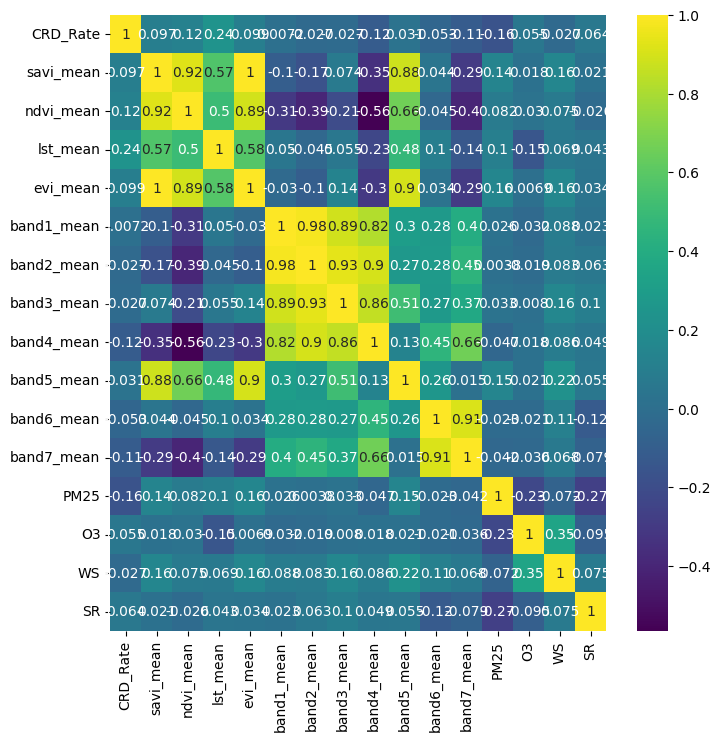

In [53]:
spring_discharge_bynet_corr = spring_discharge_bynet[['CRD_Rate','savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band2_mean', 'band3_mean', 'band4_mean', 'band5_mean', 'band6_mean', 'band7_mean', 'PM25', 'O3', 'WS', 'SR' ]]

plt.figure(figsize=(8,8))
ax = sns.heatmap(spring_discharge_bynet_corr.corr(), annot=True, cmap="viridis")
plt.show()

## **7. Machine Learning Models**

We computed four models, considering different machine learning techniques in order to compare linear and non-linear regression models (support vector regressor, random forest regressor, and multiple layer perceptron). In each model, 80% of the dataset was used as training data, and 20% of the dataset was used as test data.

In [3]:
# selected predictor variables
feature_columns  = ['ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band3_mean', 'band4_mean', 'band7_mean', 'PM25', 'WS', 'SR']
target_column = 'CRD_Rate'

Among the four models, linear regression is probably the simplest and most common analytic technique used in building a predictive model. It computes a linear relationship between the independent (predictors) and the dependent variables. However, linear regression does not analyze the correlation between predictors—a major limiting factor when considering remote sensing variables, which are highly correlated. In contrast, multiple layer perceptron with a back-propagation learning process is classified as an artificial neural network (ANN) model, and it can be used in the classification of remote sensing data. It uses a series of neuronal activities where the ideal is to have interconnection weights in a multi-layer perceptron. In this study, our model architecture consists of two dense layers with ReLU activation functions followed by dropout layers to regularize the network and prevent overfitting. The final output layer produces a single numerical prediction.

Support vectore regressor is a non-linear transformation of an machine learning techniques which works as a support vector machine classifier. They work in a higher dimensional space. Random forest regressor is based on ensemble learning, which uses the training dataset to generate multiple decision trees, making it less sensitive to the overfitting problem. The decision trees are simply combined according to their weights.

We repeate the modeling process for each season four times. For each model at each season, we calculated the mean squared error and the R-squared value.

### **7.1 Spring Data Models**

In [4]:
### Spring Data Machine Learning
X1 = spring_discharge_bynet[feature_columns]
y1 = spring_discharge_bynet[target_column]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=spring_discharge_bynet['Geography'])

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X1_train_scaled, y1_train)
predictions1_lr = linear_model.predict(X1_test_scaled)
mse1_lr = mean_squared_error(y1_test, predictions1_lr)
rmse1_lr = np.sqrt(mse1_lr)
r21_lr = r2_score(y1_test, predictions1_lr)
print("RMSE for LR Spring:", rmse1_lr)
print("R-squared for LR Spring:", r21_lr)

# SVM
svm_model = SVR()
svm_model.fit(X1_train_scaled, y1_train)
predictions1_svm = svm_model.predict(X1_test_scaled)
mse1_svm = mean_squared_error(y1_test, predictions1_svm)
rmse1_svm = np.sqrt(mse1_svm)
r21_svm = r2_score(y1_test, predictions1_svm)
print("RMSE for SVM Spring:", rmse1_svm)
print("R-squared for SVM Spring:", r21_svm)


# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X1_train_scaled, y1_train)
predictions1_rf = rf_model.predict(X1_test_scaled)
mse1_rf = mean_squared_error(y1_test, predictions1_rf)
rmse1_rf = np.sqrt(mse1_rf)
r21_rf = r2_score(y1_test, predictions1_rf)
print("RMSE for RF Spring:", rmse1_rf)
print("R-squared for RF Spring:", r21_rf)

# Multiple Layer Perceptron
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X1_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model1.compile(optimizer='adam', loss='mean_squared_error')
history1 = model1.fit(X1_train_scaled, y1_train, epochs=50, batch_size=32, validation_split=0.2)
predictions1_mlp = model1.predict(X1_test_scaled)
mse1_mlp = mean_squared_error(y1_test, predictions1_mlp)
rmse1_mlp = np.sqrt(mse1_mlp)
r21_mlp = r2_score(y1_test, predictions1_mlp)
print("R-squared for MLP Spring:", r21_mlp)
print("RMSE for MLP Spring:", rmse1_mlp)


RMSE for LR Spring: 0.390315004974376
R-squared for LR Spring: 0.1211007749107712
RMSE for SVM Spring: 0.3005158906880084
R-squared for SVM Spring: 0.47899310576811926
RMSE for RF Spring: 0.26366126081399055
R-squared for RF Spring: 0.5989474925016849
Epoch 1/50
167/167 [==============================] - 1s 3ms/step - loss: 0.4142 - val_loss: 0.1957
Epoch 2/50
167/167 [==============================] - 0s 3ms/step - loss: 0.2147 - val_loss: 0.1451
Epoch 3/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1846 - val_loss: 0.1261
Epoch 4/50
167/167 [==============================] - 0s 3ms/step - loss: 0.1643 - val_loss: 0.1222
Epoch 5/50
167/167 [==============================] - 0s 3ms/step - loss: 0.1546 - val_loss: 0.1167
Epoch 6/50
167/167 [==============================] - 0s 3ms/step - loss: 0.1574 - val_loss: 0.1144
Epoch 7/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1442 - val_loss: 0.1186
Epoch 8/50
167/167 [============================

### **7.2 Summer Data Model**

In [5]:
### Summer Data Machine Learning
X2 = summer_discharge_bynet[feature_columns]
y2 = summer_discharge_bynet[target_column]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=summer_discharge_bynet['Geography'])

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# Linear Regression
linear_model.fit(X2_train_scaled, y2_train)
predictions2_lr = linear_model.predict(X2_test_scaled)
mse2_lr = mean_squared_error(y2_test, predictions2_lr)
rmse2_lr = np.sqrt(mse2_lr)
r22_lr = r2_score(y2_test, predictions2_lr)


# SVM
svm_model.fit(X2_train_scaled, y2_train)
predictions2_svm = svm_model.predict(X2_test_scaled)
mse2_svm = mean_squared_error(y2_test, predictions2_svm)
rmse2_svm = np.sqrt(mse2_svm)
r22_svm = r2_score(y2_test, predictions2_svm)



# Random Forest
rf_model.fit(X2_train_scaled, y2_train)
predictions2_rf = rf_model.predict(X2_test_scaled)
mse2_rf = mean_squared_error(y2_test, predictions2_rf)
rmse2_rf = np.sqrt(mse2_rf)
r22_rf = r2_score(y2_test, predictions2_rf)

# Multiple Layer Perceptron
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X2_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X2_train_scaled, y2_train, epochs=50, batch_size=32, validation_split=0.2)
predictions2_mlp = model2.predict(X2_test_scaled)
mse2_mlp = mean_squared_error(y2_test, predictions2_mlp)
rmse2_mlp = np.sqrt(mse2_mlp)
r22_mlp = r2_score(y2_test, predictions2_mlp)

Epoch 1/50
167/167 [==============================] - 2s 6ms/step - loss: 0.3851 - val_loss: 0.1868
Epoch 2/50
167/167 [==============================] - 0s 2ms/step - loss: 0.2059 - val_loss: 0.1422
Epoch 3/50
167/167 [==============================] - 0s 3ms/step - loss: 0.1799 - val_loss: 0.1350
Epoch 4/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1628 - val_loss: 0.1316
Epoch 5/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1569 - val_loss: 0.1300
Epoch 6/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1510 - val_loss: 0.1299
Epoch 7/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1473 - val_loss: 0.1279
Epoch 8/50
167/167 [==============================] - 0s 2ms/step - loss: 0.1429 - val_loss: 0.1262
Epoch 9/50
167/167 [==============================] - 0s 3ms/step - loss: 0.1451 - val_loss: 0.1181
Epoch 10/50
167/167 [==============================] - 0s 3ms/step - loss: 0.1400 - val_loss: 0.1218

### **7.3 Fall Data Model**

In [6]:
### Fall Data Machine Learning
fall_discharge_bynet = fall_discharge_bynet.dropna()
X3 = fall_discharge_bynet[feature_columns]
y3 = fall_discharge_bynet[target_column]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=fall_discharge_bynet['Geography'])

scaler = StandardScaler()
X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)

# Linear Regression
linear_model.fit(X3_train_scaled, y3_train)
predictions3_lr = linear_model.predict(X3_test_scaled)
mse3_lr = mean_squared_error(y3_test, predictions3_lr)
rmse3_lr = np.sqrt(mse3_lr)
r23_lr = r2_score(y3_test, predictions3_lr)


# SVM
svm_model.fit(X3_train_scaled, y3_train)
predictions3_svm = svm_model.predict(X3_test_scaled)
mse3_svm = mean_squared_error(y3_test, predictions3_svm)
rmse3_svm = np.sqrt(mse3_svm)
r23_svm = r2_score(y3_test, predictions3_svm)



# Random Forest
rf_model.fit(X3_train_scaled, y3_train)
predictions3_rf = rf_model.predict(X3_test_scaled)
mse3_rf = mean_squared_error(y3_test, predictions3_rf)
rmse3_rf = np.sqrt(mse3_rf)
r23_rf = r2_score(y3_test, predictions3_rf)

# Multiple Layer Perceptron
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X3_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model3.compile(optimizer='adam', loss='mean_squared_error')
history3 = model3.fit(X3_train_scaled, y3_train, epochs=50, batch_size=32, validation_split=0.2)
predictions3_mlp = model3.predict(X3_test_scaled)
mse3_mlp = mean_squared_error(y3_test, predictions3_mlp)
rmse3_mlp = np.sqrt(mse3_mlp)
r23_mlp = r2_score(y3_test, predictions3_mlp)

Epoch 1/50
166/166 [==============================] - 1s 3ms/step - loss: 0.5187 - val_loss: 0.2195
Epoch 2/50
166/166 [==============================] - 0s 3ms/step - loss: 0.2418 - val_loss: 0.1581
Epoch 3/50
166/166 [==============================] - 0s 3ms/step - loss: 0.2005 - val_loss: 0.1404
Epoch 4/50
166/166 [==============================] - 1s 8ms/step - loss: 0.1792 - val_loss: 0.1385
Epoch 5/50
166/166 [==============================] - 0s 3ms/step - loss: 0.1683 - val_loss: 0.1243
Epoch 6/50
166/166 [==============================] - 0s 2ms/step - loss: 0.1590 - val_loss: 0.1208
Epoch 7/50
166/166 [==============================] - 0s 2ms/step - loss: 0.1522 - val_loss: 0.1252
Epoch 8/50
166/166 [==============================] - 0s 2ms/step - loss: 0.1493 - val_loss: 0.1153
Epoch 9/50
166/166 [==============================] - 0s 3ms/step - loss: 0.1440 - val_loss: 0.1149
Epoch 10/50
166/166 [==============================] - 0s 2ms/step - loss: 0.1420 - val_loss: 0.1095

### **7.4 Winter Data Model**

In [7]:
### Winter Data Machine Learning
winter_discharge_bynet = winter_discharge_bynet.dropna()
X4 = winter_discharge_bynet[feature_columns]
y4 = winter_discharge_bynet[target_column]


X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=winter_discharge_bynet['Geography'])
X4_train_scaled = scaler.fit_transform(X4_train)
X4_test_scaled = scaler.transform(X4_test)

# Linear Regression
linear_model.fit(X4_train_scaled, y4_train)
predictions4_lr = linear_model.predict(X4_test_scaled)
mse4_lr = mean_squared_error(y4_test, predictions4_lr)
rmse4_lr = np.sqrt(mse4_lr)
r24_lr = r2_score(y4_test, predictions4_lr)


# SVM
svm_model.fit(X4_train_scaled, y4_train)
predictions4_svm = svm_model.predict(X4_test_scaled)
mse4_svm = mean_squared_error(y4_test, predictions4_svm)
rmse4_svm = np.sqrt(mse4_svm)
r24_svm = r2_score(y4_test, predictions4_svm)



# Random Forest
rf_model.fit(X4_train_scaled, y4_train)
predictions4_rf = rf_model.predict(X4_test_scaled)
mse4_rf = mean_squared_error(y4_test, predictions4_rf)
rmse4_rf = np.sqrt(mse4_rf)
r24_rf = r2_score(y4_test, predictions4_rf)

# Multiple Layer Perceptron
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X4_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model4.compile(optimizer='adam', loss='mean_squared_error')
history4 = model4.fit(X4_train_scaled, y4_train, epochs=50, batch_size=32, validation_split=0.2)
predictions4_mlp = model4.predict(X4_test_scaled)
mse4_mlp = mean_squared_error(y4_test, predictions4_mlp)
rmse4_mlp = np.sqrt(mse4_mlp)
r24_mlp = r2_score(y4_test, predictions4_mlp)

Epoch 1/50
166/166 [==============================] - 3s 6ms/step - loss: 0.4868 - val_loss: 0.2137
Epoch 2/50
166/166 [==============================] - 1s 5ms/step - loss: 0.2333 - val_loss: 0.1615
Epoch 3/50
166/166 [==============================] - 1s 6ms/step - loss: 0.2032 - val_loss: 0.1352
Epoch 4/50
166/166 [==============================] - 1s 6ms/step - loss: 0.1723 - val_loss: 0.1328
Epoch 5/50
166/166 [==============================] - 1s 5ms/step - loss: 0.1595 - val_loss: 0.1213
Epoch 6/50
166/166 [==============================] - 1s 5ms/step - loss: 0.1511 - val_loss: 0.1184
Epoch 7/50
166/166 [==============================] - 1s 5ms/step - loss: 0.1503 - val_loss: 0.1153
Epoch 8/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1389 - val_loss: 0.1137
Epoch 9/50
166/166 [==============================] - 1s 9ms/step - loss: 0.1369 - val_loss: 0.1126
Epoch 10/50
166/166 [==============================] - 3s 16ms/step - loss: 0.1363 - val_loss: 0.110

### **7.5 Model Comparison and Evaluations**

Here, we first present the structure of the multiple layer perceptron. Then the chart and two tables show the comparision between R-Square and RMSE for all models established for each season.




In [68]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
results_rmse = {
    "Model": ["LR", "SVM", "RF", "MLP"],
    "Spring_RMSE": [rmse1_lr, rmse1_svm, rmse1_rf, rmse1_mlp],
    "Summer_RMSE": [rmse2_lr, rmse2_svm, rmse2_rf, rmse2_mlp],
    "Fall_RMSE": [rmse3_lr, rmse3_svm, rmse3_rf, rmse3_mlp],
    "Winter_RMSE": [rmse4_lr, rmse4_svm, rmse4_rf, rmse4_mlp],
}
results_rmse_df = pd.DataFrame(results_rmse)
results_rmse_df.set_index('Model', inplace=True)
results_rmse_df.head()

,Spring_RMSE,Summer_RMSE,Fall_RMSE,Winter_RMSE
Model,,,,
LR,0.390315,0.394325,0.407834,0.389794
SVM,0.300516,0.330741,0.320876,0.320580
RF,0.263661,0.296944,0.276399,0.285896
MLP,0.282484,0.304782,0.294058,0.298335


In [67]:
results_rs = {
    "Model": ["LR", "SVM", "RF", "MLP"],
    "Spring_R2": [r21_lr, r21_svm, r21_rf, r21_mlp],
    "Summer_R2": [r22_lr, r22_svm, r22_rf, r22_mlp],
    "Fall_R2": [r23_lr, r23_svm, r23_rf, r23_mlp],
    "Winter_R2": [r24_lr, r24_svm, r24_rf, r24_mlp]
}
results_rs_df = pd.DataFrame(results_rs)
results_rs_df.set_index('Model', inplace=True)
results_rs_df.head()

,Spring_R2,Summer_R2,Fall_R2,Winter_R2
Model,,,,
LR,0.121101,0.102949,0.041985,0.124707
SVM,0.478993,0.368920,0.406966,0.407952
RF,0.598947,0.491303,0.559975,0.529131
MLP,0.539641,0.464095,0.501951,0.487265


The non-linear random forest model showed the best adjustment in the test data.The model presents the lowest **RMSE (0.263661 for spring, 0.296944 for summer, 0.276399	for fall, and 0.285896 for winter)** as well as the highest **R2 (0.598947 for spring, 0.491303 for summer, 0.559975 for fall, and 0.529131 for winter)** across all seasons. In particular, the RMSE is lowest for spring but highest for summer.

This is likley due to:
- seasonal allergens and pollutants: spring is typically associated with an increase in allergens like pollen, which might have a stronger impact on respiratory health. The increase in allergens is indeed reflected in the vegetation covers and possibly wind speed from that season.
- human behavior, such as spending more time outdoors could lead to different exposure patterns to environmental factors and pollutants, affecting the relationship between remote sensing data and health outcomes.



The overall accuracy of random forest models is followed by multiple layer perceptron, support vector regression, and finally the linear regression model. The superior performance of the random forest model compared to other models can be attributed to its non-linearity, robustness, and ability to handle high-dimensional data.

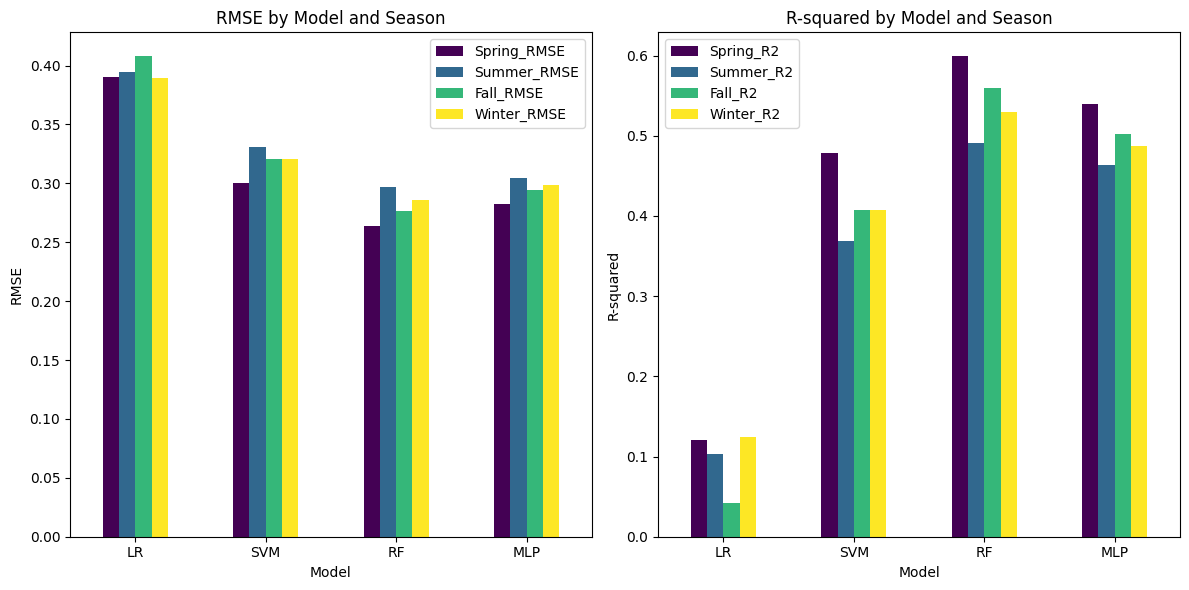

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot RMSE values
results_rmse_df.plot(kind='bar', ax=axes[0], title='RMSE by Model and Season', rot=0, cmap = 'viridis')
axes[0].set_ylabel('RMSE')

# Plot R-squared values
results_rs_df.plot(kind='bar', ax=axes[1], title='R-squared by Model and Season', rot=0, cmap = 'viridis')
axes[1].set_ylabel('R-squared')

plt.tight_layout()
plt.show()


We also compared the distribution of the predicted and actual CRD hospital discharge values produced by the random forest model. This gives us a clearer view of the extent to which our model has over or under predict hospital discharge. For all four seasons, we can see that our model performs pretty well according to the normal distributions and indeed, the distribution curve of the spring model best matches the original curve.

In [8]:
final_sp = pd.DataFrame({'Original': y1_test, 'Predicted': predictions1_rf})
final_sm = pd.DataFrame({'Original': y2_test, 'Predicted': predictions2_rf})
final_fa = pd.DataFrame({'Original': y3_test, 'Predicted': predictions3_rf})
final_wi = pd.DataFrame({'Original': y4_test, 'Predicted': predictions4_rf})

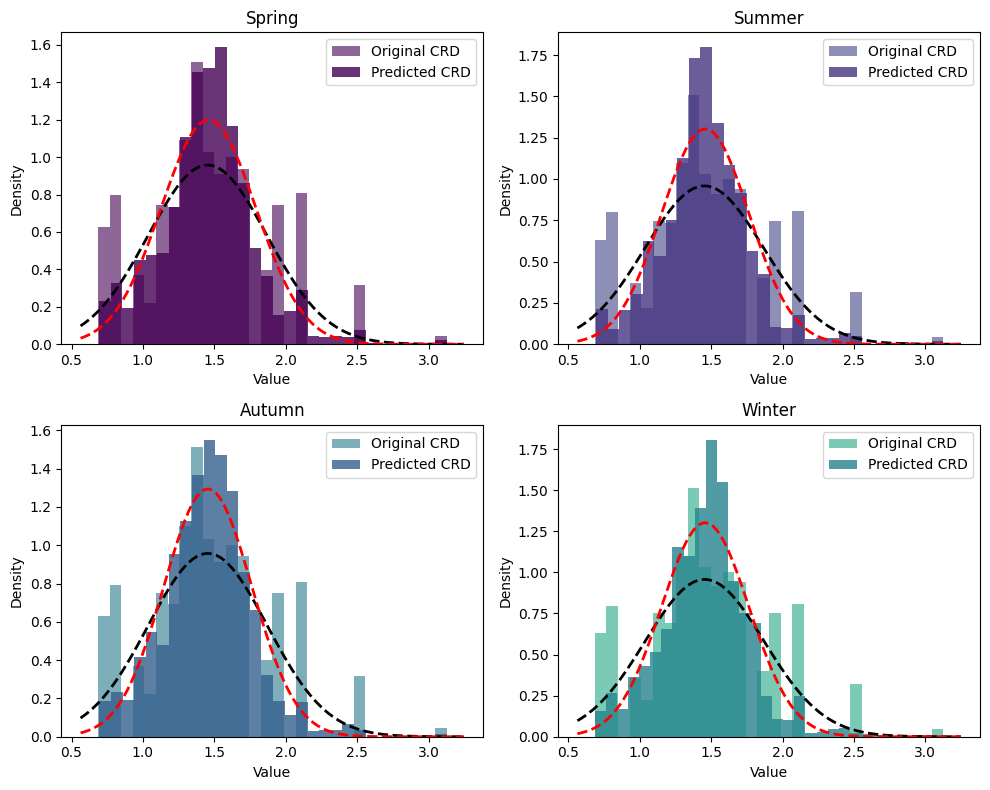

In [25]:
dataframes = [final_sp, final_sm, final_fa, final_wi]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
from matplotlib.cm import viridis

for i, df in enumerate(dataframes):
    data1 = df[['Original']]
    mu1, std1 = norm.fit(data1)

    data2 = df[['Predicted']]
    mu2, std2 = norm.fit(data2)

    row = i // 2
    col = i % 2

    color1 = viridis(i/len(dataframes)*0.8)
    color2 = viridis(i/len(dataframes)*0.6)

    axes[row, col].hist(data1, bins=30, density=True, alpha=0.6, color=color1, label='Original CRD')
    axes[row, col].hist(data2, bins=30, density=True, alpha=0.8, color=color2, label='Predicted CRD')

    xmin, xmax = axes[row, col].get_xlim()
    x1 = np.linspace(xmin, xmax, 100)
    p1 = norm.pdf(x1, mu1, std1)
    axes[row, col].plot(x1, p1, 'k--', linewidth=2)

    x2 = np.linspace(xmin, xmax, 100)
    p2 = norm.pdf(x2, mu2, std2)
    axes[row, col].plot(x2, p2, 'r--', linewidth=2)

    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Density')
    axes[row, col].set_title(seasons[i])
    axes[row, col].legend()

plt.tight_layout()
plt.show()

We would like to identify any over or underpredictions of our models. We may see that for each season, there are a few cases where CRD discharge has been significantly over/under predicted. The difference between each season is nuanced according to the visualization, but it seems like our models tend to underpredict CRD rates that were originally high.

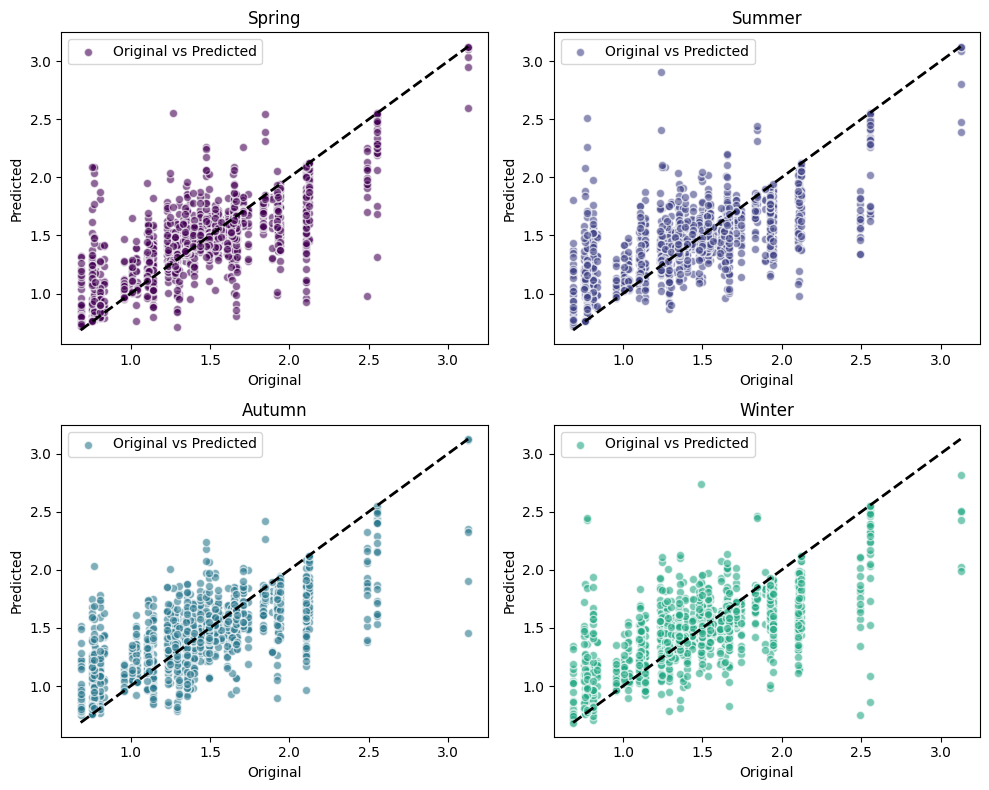

In [9]:
dataframes = [final_sp, final_sm, final_fa, final_wi]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
from matplotlib.cm import viridis

for i, df in enumerate(dataframes):
    data1 = df['Original']
    mu1, std1 = norm.fit(data1)

    data2 = df['Predicted']
    mu2, std2 = norm.fit(data2)

    row = i // 2
    col = i % 2

    color1 = viridis(i/len(dataframes)*0.8)
    color2 = viridis(i/len(dataframes)*0.6)

    axes[row, col].scatter(data1, data2, color=color1, alpha=0.6, label='Original vs Predicted', edgecolors='w')

    xmin, xmax = min(data1.min(), data2.min()), max(data1.max(), data2.max())
    x = np.linspace(xmin, xmax, 100)
    axes[row, col].plot(x, x, 'k--', linewidth=2)

    axes[row, col].set_xlabel('Original')
    axes[row, col].set_ylabel('Predicted')
    axes[row, col].set_title(seasons[i])
    axes[row, col].legend()

plt.tight_layout()
plt.show()


We selected those underpredicted values from the spring random forest model to take a closer look the counties at which it falls in. We would like to focus on underpredicted values because we want to be informed about the potential risks of CRD based on the local environment. Having a model that significantly underpredicts CRD rate will let us overlook its potential impact. We found that the following counties, especially Columbia, Lebanon, McKean, Wayne, Junita, and Jefferson, seems to contain a significant number of grids that have higher CRD rates but are underpredicted.

In [ ]:
target_column_map = ['CRD_Rate', 'Geography']
y1 = spring_discharge_bynet[target_column_map]

X1_train, X1_test, y1_train, y1_test_2 = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=spring_discharge_bynet['Geography'])
original_rate = y1_test_2['CRD_Rate']
geography = y1_test_2['Geography']

final_sp = pd.DataFrame({'Original': original_rate, 'County': geography, 'Predicted': predictions1_rf})

In [ ]:
selected_rows = final_sp[final_sp['Original'].astype(float) > final_sp['Predicted']]

In [ ]:
county_rank = selected_rows.groupby('County').size().rank(ascending=False)
sorted_df = county_rank.sort_values(ascending=False)

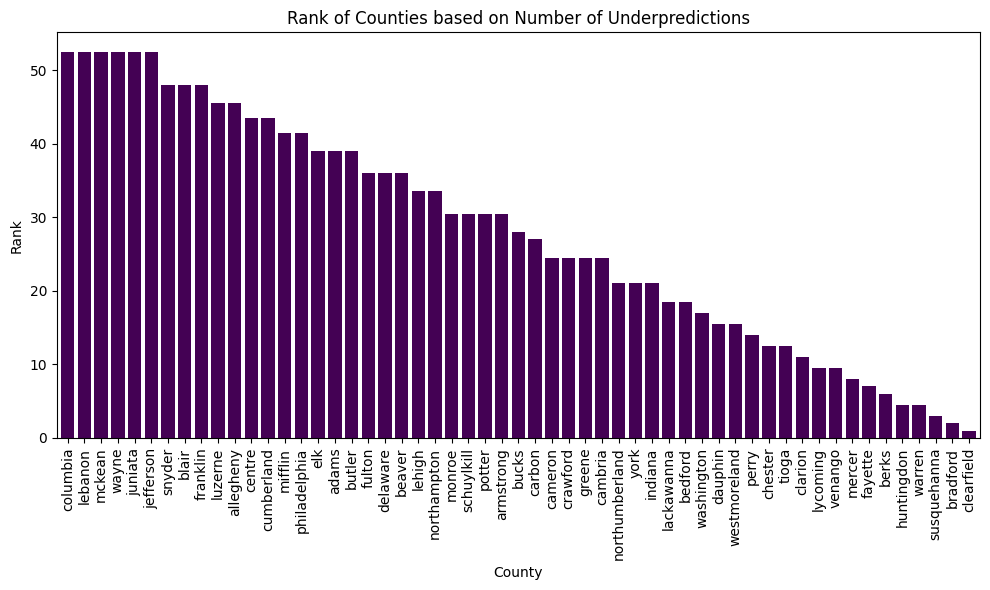

In [71]:
sorted_df.plot(kind='bar', figsize=(10, 6), cmap = 'viridis', width=0.8)

# Add labels and title
plt.xlabel('County')
plt.ylabel('Rank')
plt.title('Rank of Counties based on Number of Underpredictions')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show plot
plt.tight_layout()
plt.show()

## **8. Conclusions**

In summary, we investigated the effectiveness of four machine learning models, linear regression, support vector regression, random forest regression, and multiple layer perceptron, in predicting hospitalization discharge of patients with chronic respiratory disease in the state of Pennsylvania using a combination of remote sensing data and air quality variables. Drawing on the methodologies and workflows of Alvarez-Mendoza et al., we acquired the average of all Landsat 8 level 2 images from Spring 2022 to Spring 2023 by season via the Google Earth Engine API, from which we computed the vegetation indices (NDVI, EVI, and SAVI) and land surface temperature. We took the mean of air quality field measurements from stations across Pennsylvania and summarized the average wind speed, PM2.5, solar radiation, and ozone level by season. We aggregated all variables into a fishnet grid of Pennsylvania, on which we ran our models by season and computed the RMSE and R-squared.

Upon examining our input data, we have found that there are significant urban-rural differences in CRD risks, where hospitalization due to CRD is much higher in Philadelphia and surrounding counties as well as in Pittsburgh. In addition to that, a few counties in the northern and central part of the state also stand out as having higher CRD risks. Similarly, vegetation indices are higher in the southeastern and southwestern part of the state but lower in the central part of the state. PM2.5 tends to be higher in winter and summer while lower in spring and fall. Some counties in the northern and western part of the state stand out.

Among the four models, we found that the non-linear random forest model showed the best adjustment in the test data. The model presents the lowest RMSE and the highest R-Squared across all seasons. The model performs the best in spring and worst in summer. The overall accuracy of the random forest model is followed by multiple layer perceptron, support vector regression, and finally the linear regression one. In this case, random forest is the more robust method because it is a method that combines multiple decision trees. Each tree is trained on a random subset of features and observations. This randomness helps reduce the variance of the model, making it less susceptible to overfitting, especially in high-dimensional spaces. We delved further into the accuracy of this random forest model by looking at the degree to which it over
It seems that the random forest models are over-predicting CRD hospitalization discharge that’s in the middle range, but under-predicting discharges of grids that had extremely high or low actual discharges. This would be problematic as for healthcare professionals and policy makers, an ideal model would be the one that do not underestimate the risks.

As such, we dug further into the counties where underprediction most often occurs. We’ve found the following counties, especially Columbia, Lebanon, McKean, Wayne, Junita, and Jefferson, seem to experience the most significant number of underpredictions. Most of these counties are located at central or northern Pennsylvania and are less populated. We believe that more attention should be given to these counties in terms of the occurrence of CRD in relation to the local environment.

Reflecting on the overall study design, there are a couple of limitations that we have to acknowledge and work towards addressing them in future attempts. Firstly, we chose to compute Voronoi polygons to characterize the influence area of air quality monitoring stations. While Voronoi polygons is good at making spatial interpolations such that each station will be associated with a polygon representing the area where it has the closet proximity, it does not take into account local geographies. For example, a station located on one side of a hill might be collecting air quality measures that is completely different from what is a happening on the other side of the hill. Nevertheless, the Voronoi polygon algorithm will group the areas on both side of the hill into one influence area. This will definitely introduce errors into our model.

Secondly, missing data is a concern in this project. There’s one county in Pennsylvania with missing hospital discharge data. We originally expected each county in Pennsylvania to have their own air quality data collecting station. However, upon examining the data, we found that this is not the case. On top of that, different stations could be collecting completely different air quality measures. Some stations are only collecting for half of the month while other might be missing data for an entire month. We also found that Philadelphia County’s air quality data is maintained separately than other counties and are stored in a different format. This leads us to make a lot of compromises assumptions based on the available data and previous years’ record in order to determine an approximate value for the month we need.

Thirdly, the spatial unit of our analysis could potentially introduce uncertainties into our model. There has been literature that questions the accuracy of using fishnet versus using hexagons. Fishnet grids can draw our eyes to the straight, unbroken, parallel lines which may inhibit the underlying patterns in the data, whereas hexagons tend to break up the lines and allow any curvature of the patterns in the data to be seen more clearly and easily. While using a standardize spatial unit makes the modeling process easier, we have to do several rounds of area-weighted reaggregation to aggregate data at the county or measuring station influence area level into the fishnet. The hospital data is at the county level, but we believe that there will certainly be intra-county variations in terms of the CRD discharges that this county level data had missed.

Fourthly, in terms of the scope of the analysis, we hope we could improve upon the original paper by extending the temporal scale of analysis to include multiple years of data, rather than merely accounting for seasonal variations (especially if the hospital data are not at seasonal level). It will be great to look at how previous years data could inform us about future trends of hospital discharge, though this would require a lot more effort in collecting and cleaning the air quality data given all its limitations at this point. We would also like to include more machine learning models for comparison to see how linear/non-linear model perform in making predictions.

Regardless, the takeaway from this project will contribute to our understanding of spatial and temporal variations in CRD risks in relation to local environment in the state of Pennsylvania. It also improves our understanding of the significant environmental and atmospheric factors leading to higher CRD risks in Pennsylvania as well as the power of different machine learning models in making future predictions. The random forest model outperformed other models in this project, especially when being run on the spring data, and we have identified several counties where under-predictions is an issues. We hope that our attempt to improve on Alvarez-Mendoza et al.’s study could provide an approach of spatial distribution of air pollutants and its possible relationship with epidemiological data, serving a feasible alternative to the governmental health institutions.